In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.gravity_processing as grav

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import plotly.figure_factory as ff
import seaborn as sns

sns.set_theme()
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle
import random


import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
plot = True
# plot = False
runs = 100

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    "../inversion_layers/Ross_Sea_starting_prisms.zarr",
)

# partial bouguer corrected gravity data
df_anomalies = pd.read_csv(
    # "../synthetic_data/Ross_Sea_gravity_anomalies.csv.gz",
    # "../synthetic_data/Ross_Sea_gravity_anomalies_survey.csv.gz",
    "../synthetic_data/Ross_Sea_gravity_anomalies_survey_noise.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
df_anomalies = df_anomalies[df_anomalies.test == False]

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]
layer_spacing = 5e3
grav_spacing = layer_spacing
print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
constraints = pd.read_csv(
    "../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)

# subset buffer zone points
buffer_constraints = utils.points_inside_region(
    constraints, inversion_region, reverse=True, names=("easting", "northing")
)
buffer_constraints["buffer"] = True
buffer_constraints["inside"] = False

# subset inversion zone points
inv_constraints = utils.points_inside_region(
    constraints, inversion_region, names=("easting", "northing")
)
inv_constraints["buffer"] = False

# merge inversion and buffer points
constraints = pd.concat([buffer_constraints, inv_constraints])

print(f"Total constraints:{len(constraints)}")
print(f"Buffer constraints:{len(constraints[constraints.buffer])}")
print(f"Inside ice shelf constraints:{len(constraints[constraints.inside])}")

bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

starting_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed_semiregular.zarr").z

# final inverted bathymetry model
# fname = "../results/weights_mask_prism_results.csv.gz"
# inverted_bathy = pd.read_csv(
#     fname,
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )
# inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
#     inverted_bathy.columns[-1]
# ]

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-40000.0, 260000.0, -1800000.0, -1400000.0)
buffer region =  [-80000.0, 300000.0, -1840000.0, -1360000.0]
Total constraints:3542
Buffer constraints:2528
Inside ice shelf constraints:39


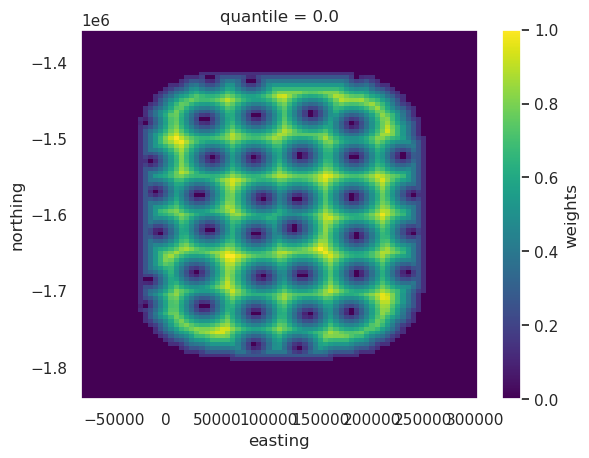

In [4]:
starting_prisms.weights.plot()

In [5]:
# fig = maps.plot_grd(
#     bed,
#     fig_height=8,
#     region=buffer_region,
#     show_region=inversion_region,
#     cbar_labels="bed elevation",
#     cbar_units="m",
# )
# fig.plot(
#     x=constraints[constraints.buffer].easting,
#     y=constraints[constraints.buffer].northing,
#     style="c.1c",
#     fill="black",
# )
# fig.plot(
#     x=constraints[constraints.buffer==False].easting,
#     y=constraints[constraints.buffer==False].northing,
#     style="c.08c",
#     fill="red",
# )
# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     style="c.06c",
#     fill="blue",
# )
# fig.plot(
#     x=constraints[constraints.inside==False].easting,
#     y=constraints[constraints.inside==False].northing,
#     style="c.02c",
#     fill="orange",
# )
# fig.plot(
#     "../data/Ross_Sea_outline.shp",
#     pen="0.2p,black",
# )

# fig.show()

# Add uncertainties 
2.9 mGal for gravity data

5 m for constraints outside ice shelf
2% depth from ice surface for constraints within ice shelf

In [6]:
# calculate upper and lower bounds
constraints["low_lim"] = constraints.upward - constraints.uncert
constraints["high_lim"] = constraints.upward + constraints.uncert

print(
    f"mean uncertainty inside RIS: {np.nanmean(constraints[constraints.inside].uncert)} m"
)
print(
    f"mean uncertainty outside RIS: {np.nanmean(constraints[constraints.inside==False].uncert)} m"
)
constraints.describe()

mean uncertainty inside RIS: 9.098066280714873 m
mean uncertainty outside RIS: 5.0 m


,northing,easting,upward,uncert,low_lim,high_lim
count,3.542000e+03,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000
mean,-1.598879e+06,108292.121820,-550.694628,5.045123,-555.739751,-545.649505
std,1.713490e+05,139451.979414,144.422261,0.486578,144.411727,144.434434
min,-1.840000e+06,-80000.000000,-969.619486,5.000000,-974.619486,-964.619486
25%,-1.780000e+06,-35000.000000,-643.893550,5.000000,-648.893550,-638.893550
50%,-1.597500e+06,105000.000000,-551.693350,5.000000,-556.693350,-546.577198
75%,-1.415000e+06,255000.000000,-443.250754,5.000000,-448.250754,-438.180376
max,-1.360000e+06,300000.000000,-164.541535,12.797503,-169.541535,-159.541535


In [7]:
df_anomalies["uncert"] = 0.6
df_anomalies

,northing,easting,Gobs,test,upward,bed_forward,Gobs_shift,misfit,reg,res,uncert
0,-1800000.0,-40000.0,14.221879,False,1000.0,1.588803,8.463925,6.875122,6.583004,0.292119,0.6
2,-1800000.0,-35000.0,15.023846,False,1000.0,2.731633,9.265892,6.534258,6.664664,-0.130406,0.6
4,-1800000.0,-30000.0,16.539822,False,1000.0,3.687668,10.781868,7.094200,6.543382,0.550817,0.6
6,-1800000.0,-25000.0,16.607955,False,1000.0,4.530236,10.850001,6.319765,6.249785,0.069979,0.6
8,-1800000.0,-20000.0,16.435194,False,1000.0,4.885449,10.677240,5.791791,6.126027,-0.334236,0.6
...,...,...,...,...,...,...,...,...,...,...,...
19472,-1400000.0,240000.0,-16.337404,False,1000.0,-15.731898,-22.095358,-6.363461,-6.533506,0.170045,0.6
19474,-1400000.0,245000.0,-17.751599,False,1000.0,-15.879610,-23.509553,-7.629944,-7.822860,0.192917,0.6
19476,-1400000.0,250000.0,-20.384565,False,1000.0,-16.379783,-26.142520,-9.762737,-9.479548,-0.283189,0.6
19478,-1400000.0,255000.0,-22.112194,False,1000.0,-17.321311,-27.870148,-10.548837,-10.649994,0.101157,0.6


In [8]:
def plot_stats(
    title,
    grav_dfs,
    mask="../data/Ross_Sea_outline.shp",
):
    residuals = [utils.RMSE(df[list(df.columns)[-1]]) for df in grav_dfs]

    # convert residuals into weights
    weights = [1 / (x**2) for x in residuals]

    stats = inv_utils.model_ensemble_stats(topos, weights=weights)
    merged, z_mean, z_stdev, weighted_mean, weighted_stdev, z_min, z_max = stats

    grids = [
        z_mean,
        z_stdev,
        z_min,
        weighted_mean,
        weighted_stdev,
        z_max,
    ]

    grids = [
        utils.mask_from_shp(shapefile=mask, xr_grid=i, masked=True, invert=False)
        for i in grids
    ]

    subplot_titles = [
        "z_mean",
        "z_stdev",
        "z_min",
        "weighted_mean",
        "weighted_stdev",
        "z_max",
    ]

    fig = maps.subplots(
        grids=grids,
        region=inversion_region,
        dims=(2, 3),
        fig_title=title,
        subplot_titles=subplot_titles,
        cbar_labels=["m" for x in grids],
        autolabel="a)+JTL",
        fig_height=10,
        margins="1c",
        # grd2cpt=True,
        cmaps=[
            "rain",
            "inferno",
            "rain",
            "rain",
            "inferno",
            "rain",
        ],
        reverse_cpt=True,
        points=constraints[constraints.inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style="x.2c",
        points_pen="1.2p",
        # hist=True,
        # cbar_yoffset=1.5,
    )
    fig.show()

# Setup Monte-Carlo sampling
* define sampling methods for the uncertainties of both the gravity and constraints data
* run full inversion with sampled gravity
    * including: 
        * corrections for parital bouguer and starting bed
        * DC shift
        * regional / residual seperation
        * inversion
* find standard deviation per grid cell of all resulting inverted bathymetry models

## Run inversion workflow

In [10]:
# get ice shelf mask
# mask = gpd.read_file("../data/Ross_Sea_outline.shp")
# mask = mask.dissolve()

# df_buffer, _, _ = inv_utils.inversion_buffer_points(
#     buffer_width = 40e3,
#     grid = bed,
#     mask = mask,
#     plot = True,
# )
# df_buffer

In [11]:
kwargs = {
    "grav_spacing": grav_spacing,
    "inversion_region": inversion_region,
    "buffer_region": buffer_region,
    "layer_spacing": layer_spacing,
    # optional:
    "weights_grid": starting_prisms.weights,
    "starting_bed_prisms": starting_prisms,
    "starting_bed": starting_bed,
    "constraint_weights": 1 / (constraints.uncert**2),
    "dampings": np.logspace(-15, -5, num=8),
    "mindists": np.linspace(1, 5e3, 8),
}
inversion_args = {
    "input_grav_column": "Gobs_shift",
    "apply_weights": False,
    "weights_after_solving": True,
    "max_iterations": 100,
    "l2_norm_tolerance": 0.15,
    "delta_l2_norm_tolerance": 1.02,
    "deriv_type": "annulus",
    "solver_type": "scipy least squares",
    "solver_damping": 0.06309573444801936,
}
starting_args = dict(
    water_density=1024,
    sediment_density=2300,
    # sediment_density = 2500,
)

## Full (gravity, constraints, density)

File ../data/monte_carlo_results/Ross_Sea_monte_carlo_full_2500_dens.zarr not found, creating new file



  0%|          | 0/20 [00:00<?, ?it/s]

starting Monte Carlo uncertainty analysis at run 0 of 20
saving results to ../data/monte_carlo_results/Ross_Sea_monte_carlo_full_2500_dens.zarr

Recalculating starting bed
Recalculating bed gravity
Recalculating regional field
Finished inversion 1 of 20
Finished inversion 2 of 20
Finished inversion 3 of 20
Finished inversion 4 of 20
Finished inversion 5 of 20


/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/utils.py:177: UserWarning: Warning: best minimum distance parameter (1.0) for verde.SplineCV() is at the limit of provided values ((1.0, 715.1428571428571)) and thus is likely not a global minimum, expand the range of values with 'mindists'
  warnings.warn(f"Warning: best minimum distance parameter ({spline.mindist_}) for verde.SplineCV() is at the limit of provided values ({mindists[0], mindists[1]}) and thus is likely not a global minimum, expand the range of values with 'mindists'")


Finished inversion 6 of 20
Finished inversion 7 of 20
Finished inversion 8 of 20
Finished inversion 9 of 20
Finished inversion 10 of 20
Finished inversion 11 of 20
Finished inversion 12 of 20


/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/utils.py:177: UserWarning: Warning: best minimum distance parameter (1.0) for verde.SplineCV() is at the limit of provided values ((1.0, 715.1428571428571)) and thus is likely not a global minimum, expand the range of values with 'mindists'
  warnings.warn(f"Warning: best minimum distance parameter ({spline.mindist_}) for verde.SplineCV() is at the limit of provided values ({mindists[0], mindists[1]}) and thus is likely not a global minimum, expand the range of values with 'mindists'")


Finished inversion 13 of 20


/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/utils.py:177: UserWarning: Warning: best minimum distance parameter (1.0) for verde.SplineCV() is at the limit of provided values ((1.0, 715.1428571428571)) and thus is likely not a global minimum, expand the range of values with 'mindists'
  warnings.warn(f"Warning: best minimum distance parameter ({spline.mindist_}) for verde.SplineCV() is at the limit of provided values ({mindists[0], mindists[1]}) and thus is likely not a global minimum, expand the range of values with 'mindists'")


Finished inversion 14 of 20
Finished inversion 15 of 20


/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/utils.py:177: UserWarning: Warning: best minimum distance parameter (1.0) for verde.SplineCV() is at the limit of provided values ((1.0, 715.1428571428571)) and thus is likely not a global minimum, expand the range of values with 'mindists'
  warnings.warn(f"Warning: best minimum distance parameter ({spline.mindist_}) for verde.SplineCV() is at the limit of provided values ({mindists[0], mindists[1]}) and thus is likely not a global minimum, expand the range of values with 'mindists'")


Finished inversion 16 of 20
Finished inversion 17 of 20
Finished inversion 18 of 20
Finished inversion 19 of 20
Finished inversion 20 of 20


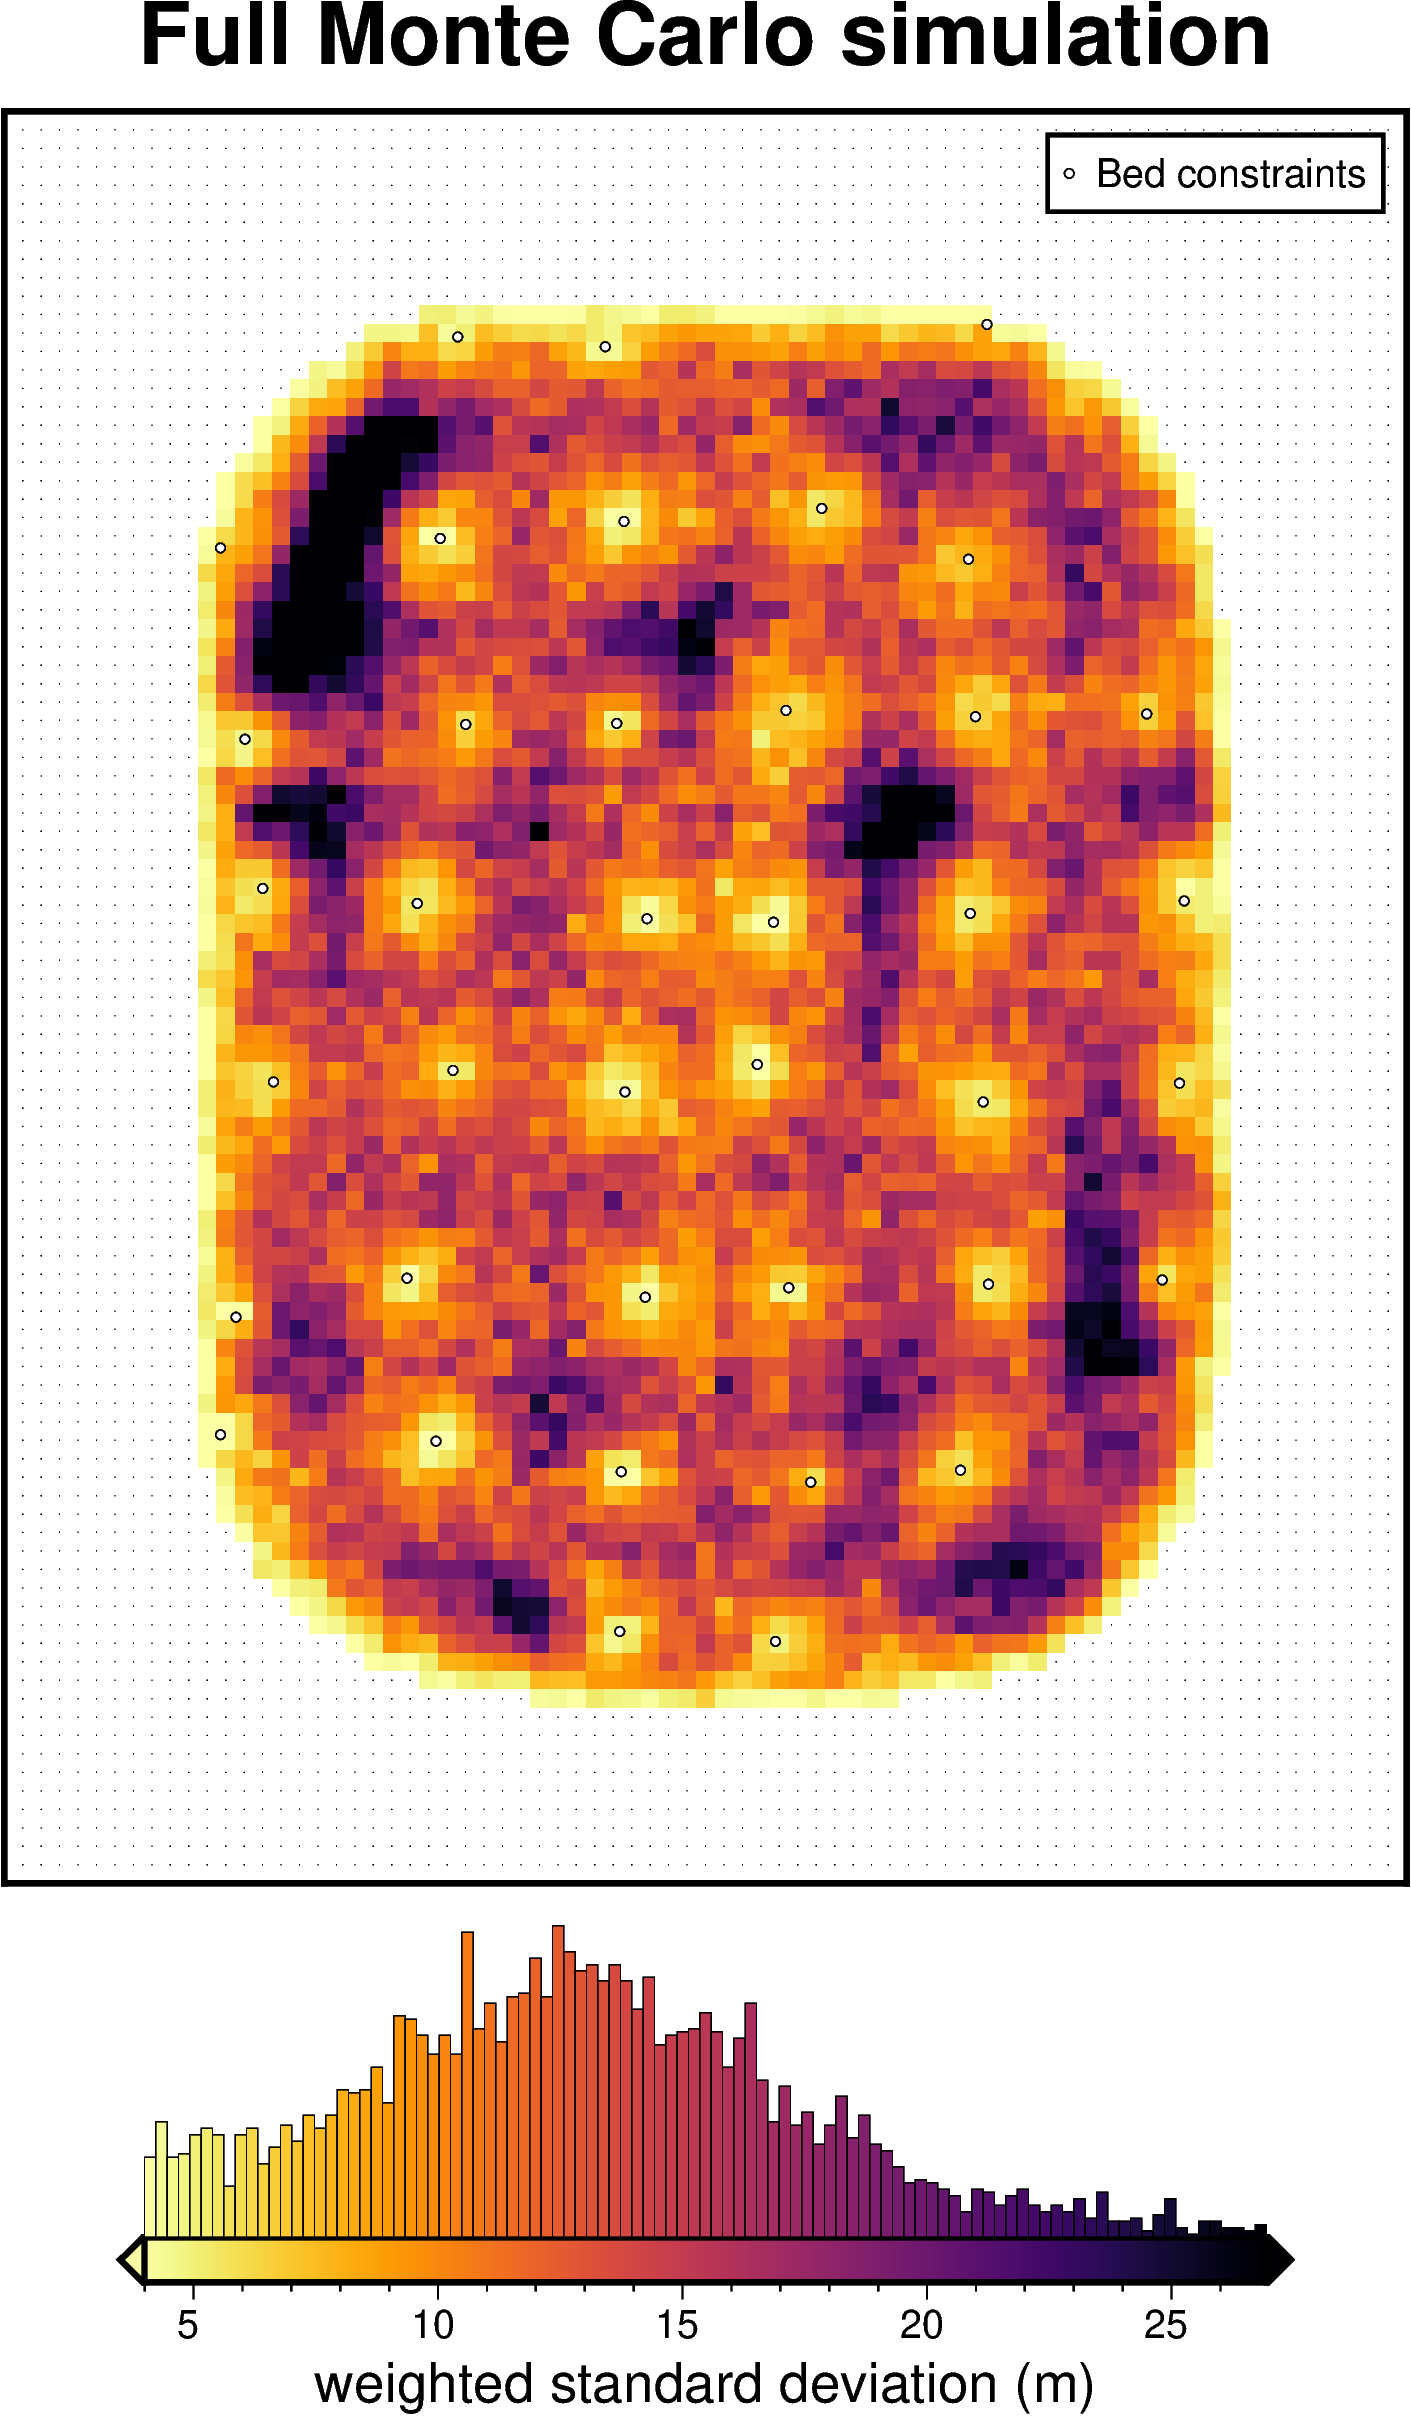

{'density_contrast': '1409.615684763413 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '6 seconds', 'average_iteration_time': '0.52 seconds', 'Final misfit RMSE / L2-norm': '0.6254 /0.7909 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.47289144061505795, 0.4823203356936574, 0.5584072694182396, 0.5422251550480723, 0.5207425272092223, 0.49089179188013077, 0.492455312050879, 0.5466727809980512, 0.5277506690472364, 0.5542853828519583, 0.5156906330958009, 0.5257025640457869]}
{'water_density': 1016.1009965624725, 'sediment_density': 2425.7166813258855}


In [12]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_full_2500_dens.zarr"
runs = 20
full_results = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    sample_grav=True,  # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    sample_water_density=True,  # will recalculate bouguer anomalies and regional field
    sample_sediment_density=True,  # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Full Monte Carlo simulation",
    **kwargs,
)

topos, params, values, grav_dfs = full_results

print(params[-1])
print(values[-1])

In [16]:
residuals = [utils.RMSE(df[list(df.columns)[-1]]) for df in grav_dfs]

# convert residuals into weights
weights = [1 / (x**2) for x in residuals]

stats = inv_utils.model_ensemble_stats(topos, weights=weights)
merged, z_mean, z_stdev, weighted_mean, weighted_stdev, z_min, z_max = stats

grids = [
    z_mean,
    z_stdev,
    z_min,
    weighted_mean,
    weighted_stdev,
    z_max,
]

In [27]:
inverted_bed = xr.open_zarr(
    "../synthetic_data/Ross_Sea_inverted_bed_survey_noise_2500_dens.zarr"
).z
bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

bed = bed.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
inverted_bed = inverted_bed.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
weighted_mean = weighted_mean.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
z_mean = z_mean.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)

20.65475304104601

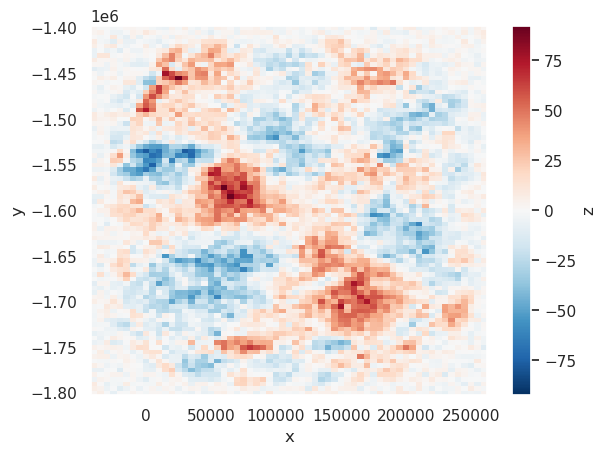

In [25]:
(bed - inverted_bed).plot()
inv_utils.RMSE(bed - inverted_bed)

19.975116365400226

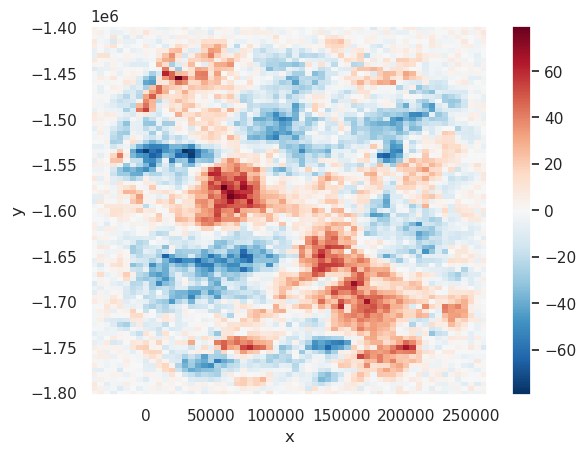

In [28]:
(bed - z_mean).plot()
inv_utils.RMSE(bed - z_mean)

20.01870933626797

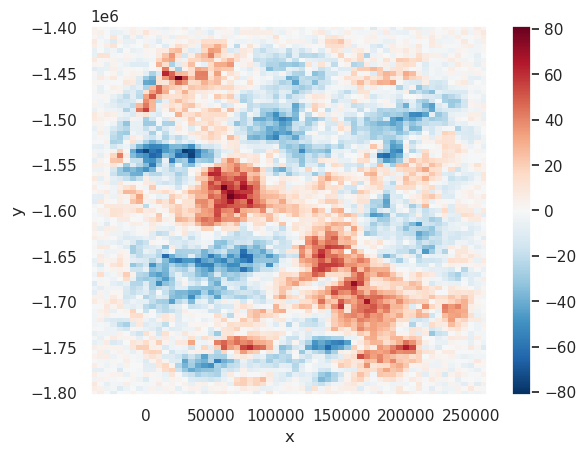

In [26]:
(bed - weighted_mean).plot()
inv_utils.RMSE(bed - weighted_mean)

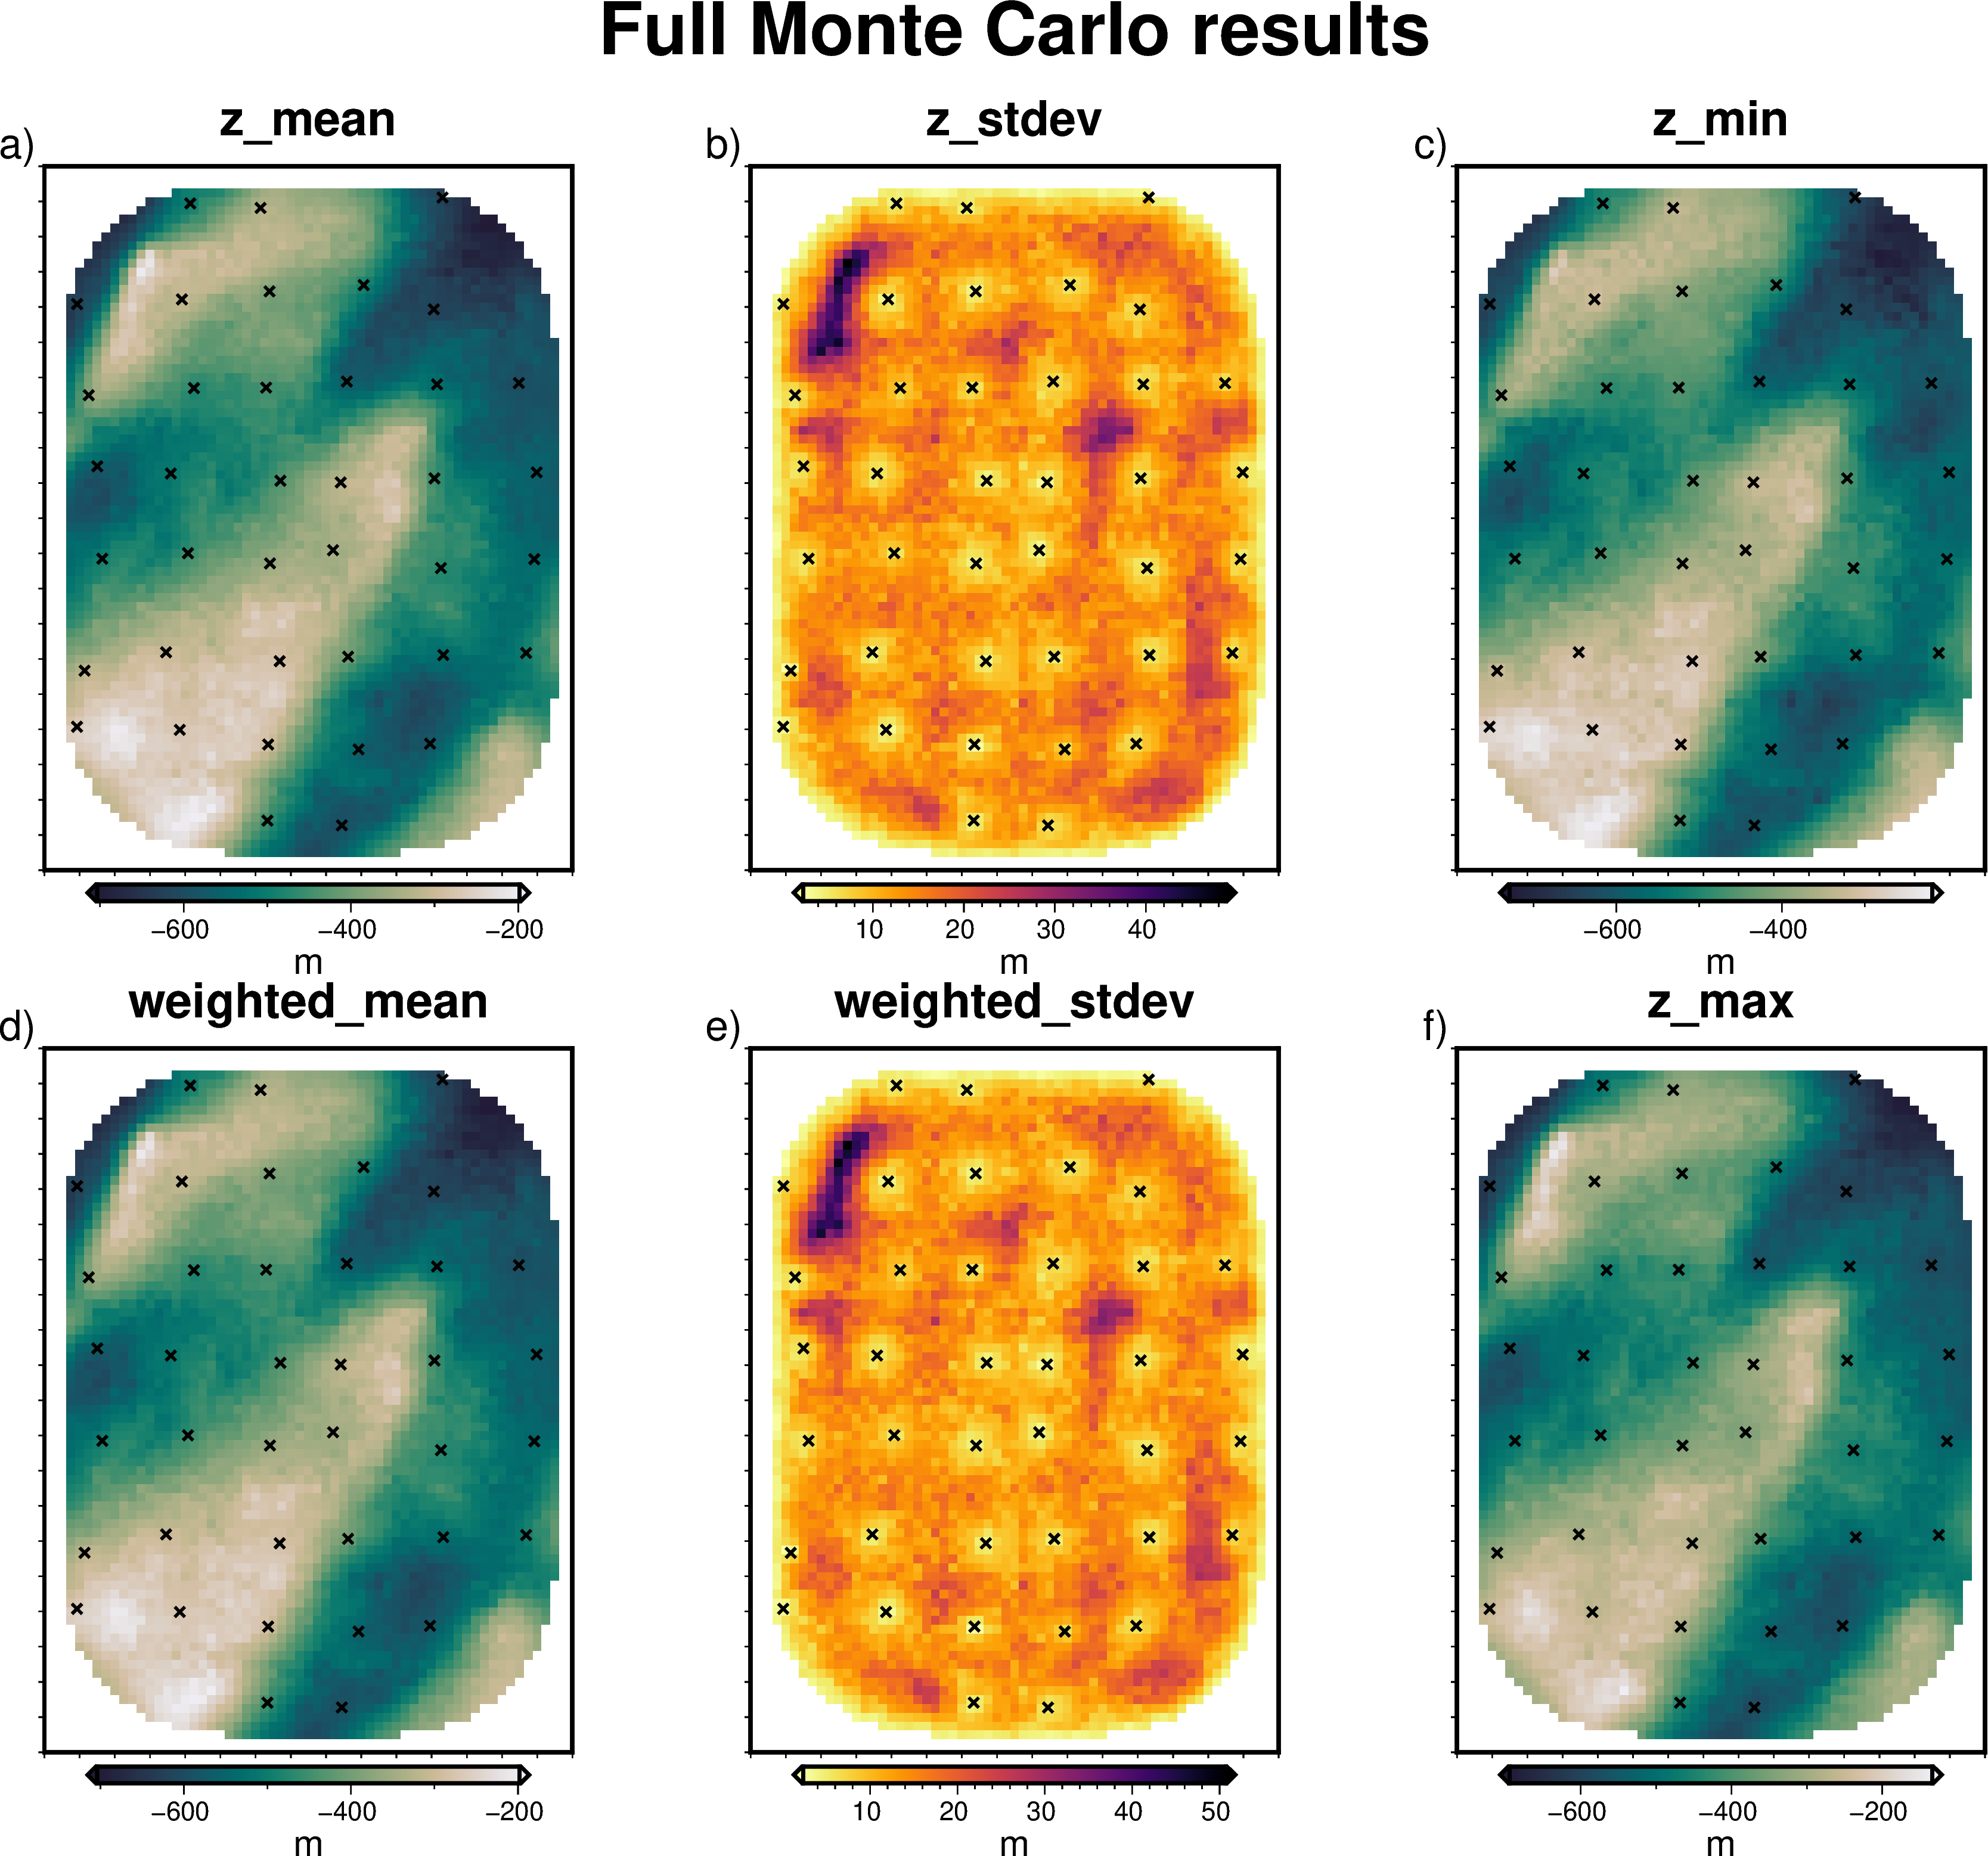

In [13]:
if plot:
    plot_stats(
        "Full Monte Carlo results",
        grav_dfs,
    )

## Gravity

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

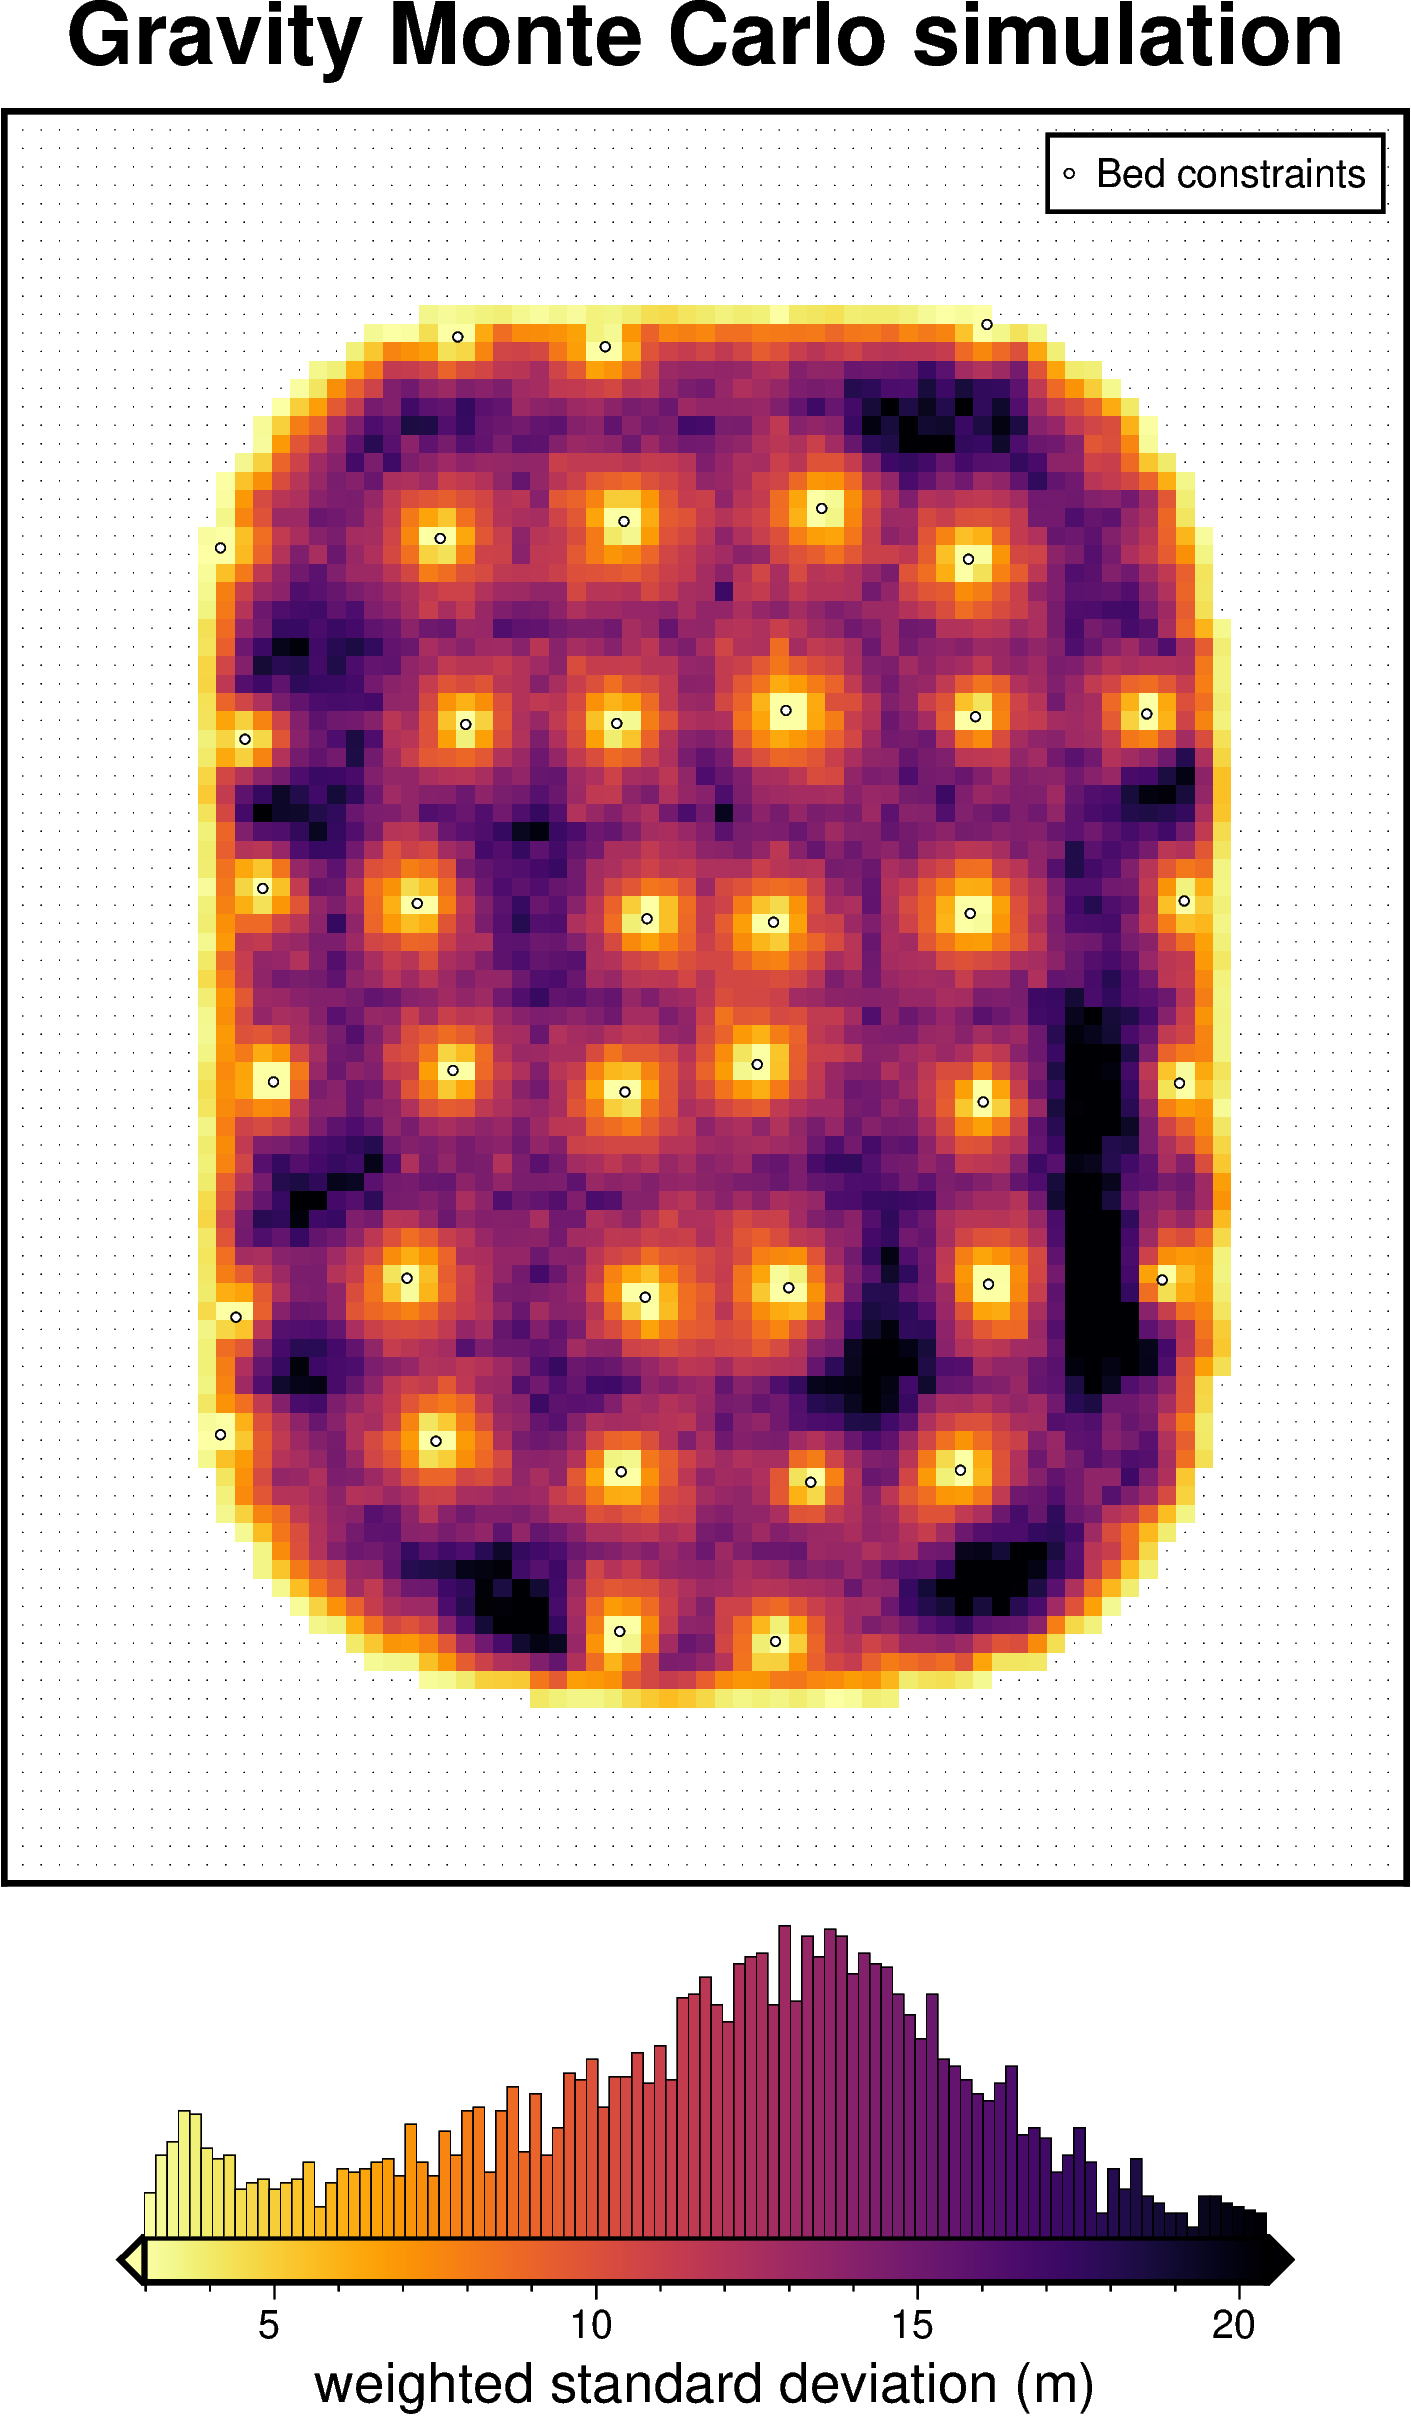

{'density_contrast': '1276 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '7 seconds', 'average_iteration_time': '0.53 seconds', 'Final misfit RMSE / L2-norm': '0.5992 /0.7741 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.5327470973134041, 0.4832274382933974, 0.5482663437724113, 0.4835751364007592, 0.49314659740775824, 0.5828195409849286, 0.5722388569265604, 0.5112155824899673, 0.5175409959629178, 0.5184914218261838, 0.5131719717755914, 0.5787012930959463, 0.5797476945444942, 0.5384192215278745]}
{'water_density': 1024, 'sediment_density': 2300}


In [15]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_gravity.zarr"

grav_results = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    sample_grav=True,  # will recalculate regional field
    # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field
    # sample_water_density = True,    # will recalculate bouguer anomalies and regional field
    # sample_sediment_density = True, # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Gravity Monte Carlo simulation",
    **kwargs,
)

topos, params, values, grav_dfs = grav_results

print(params[-1])
print(values[-1])

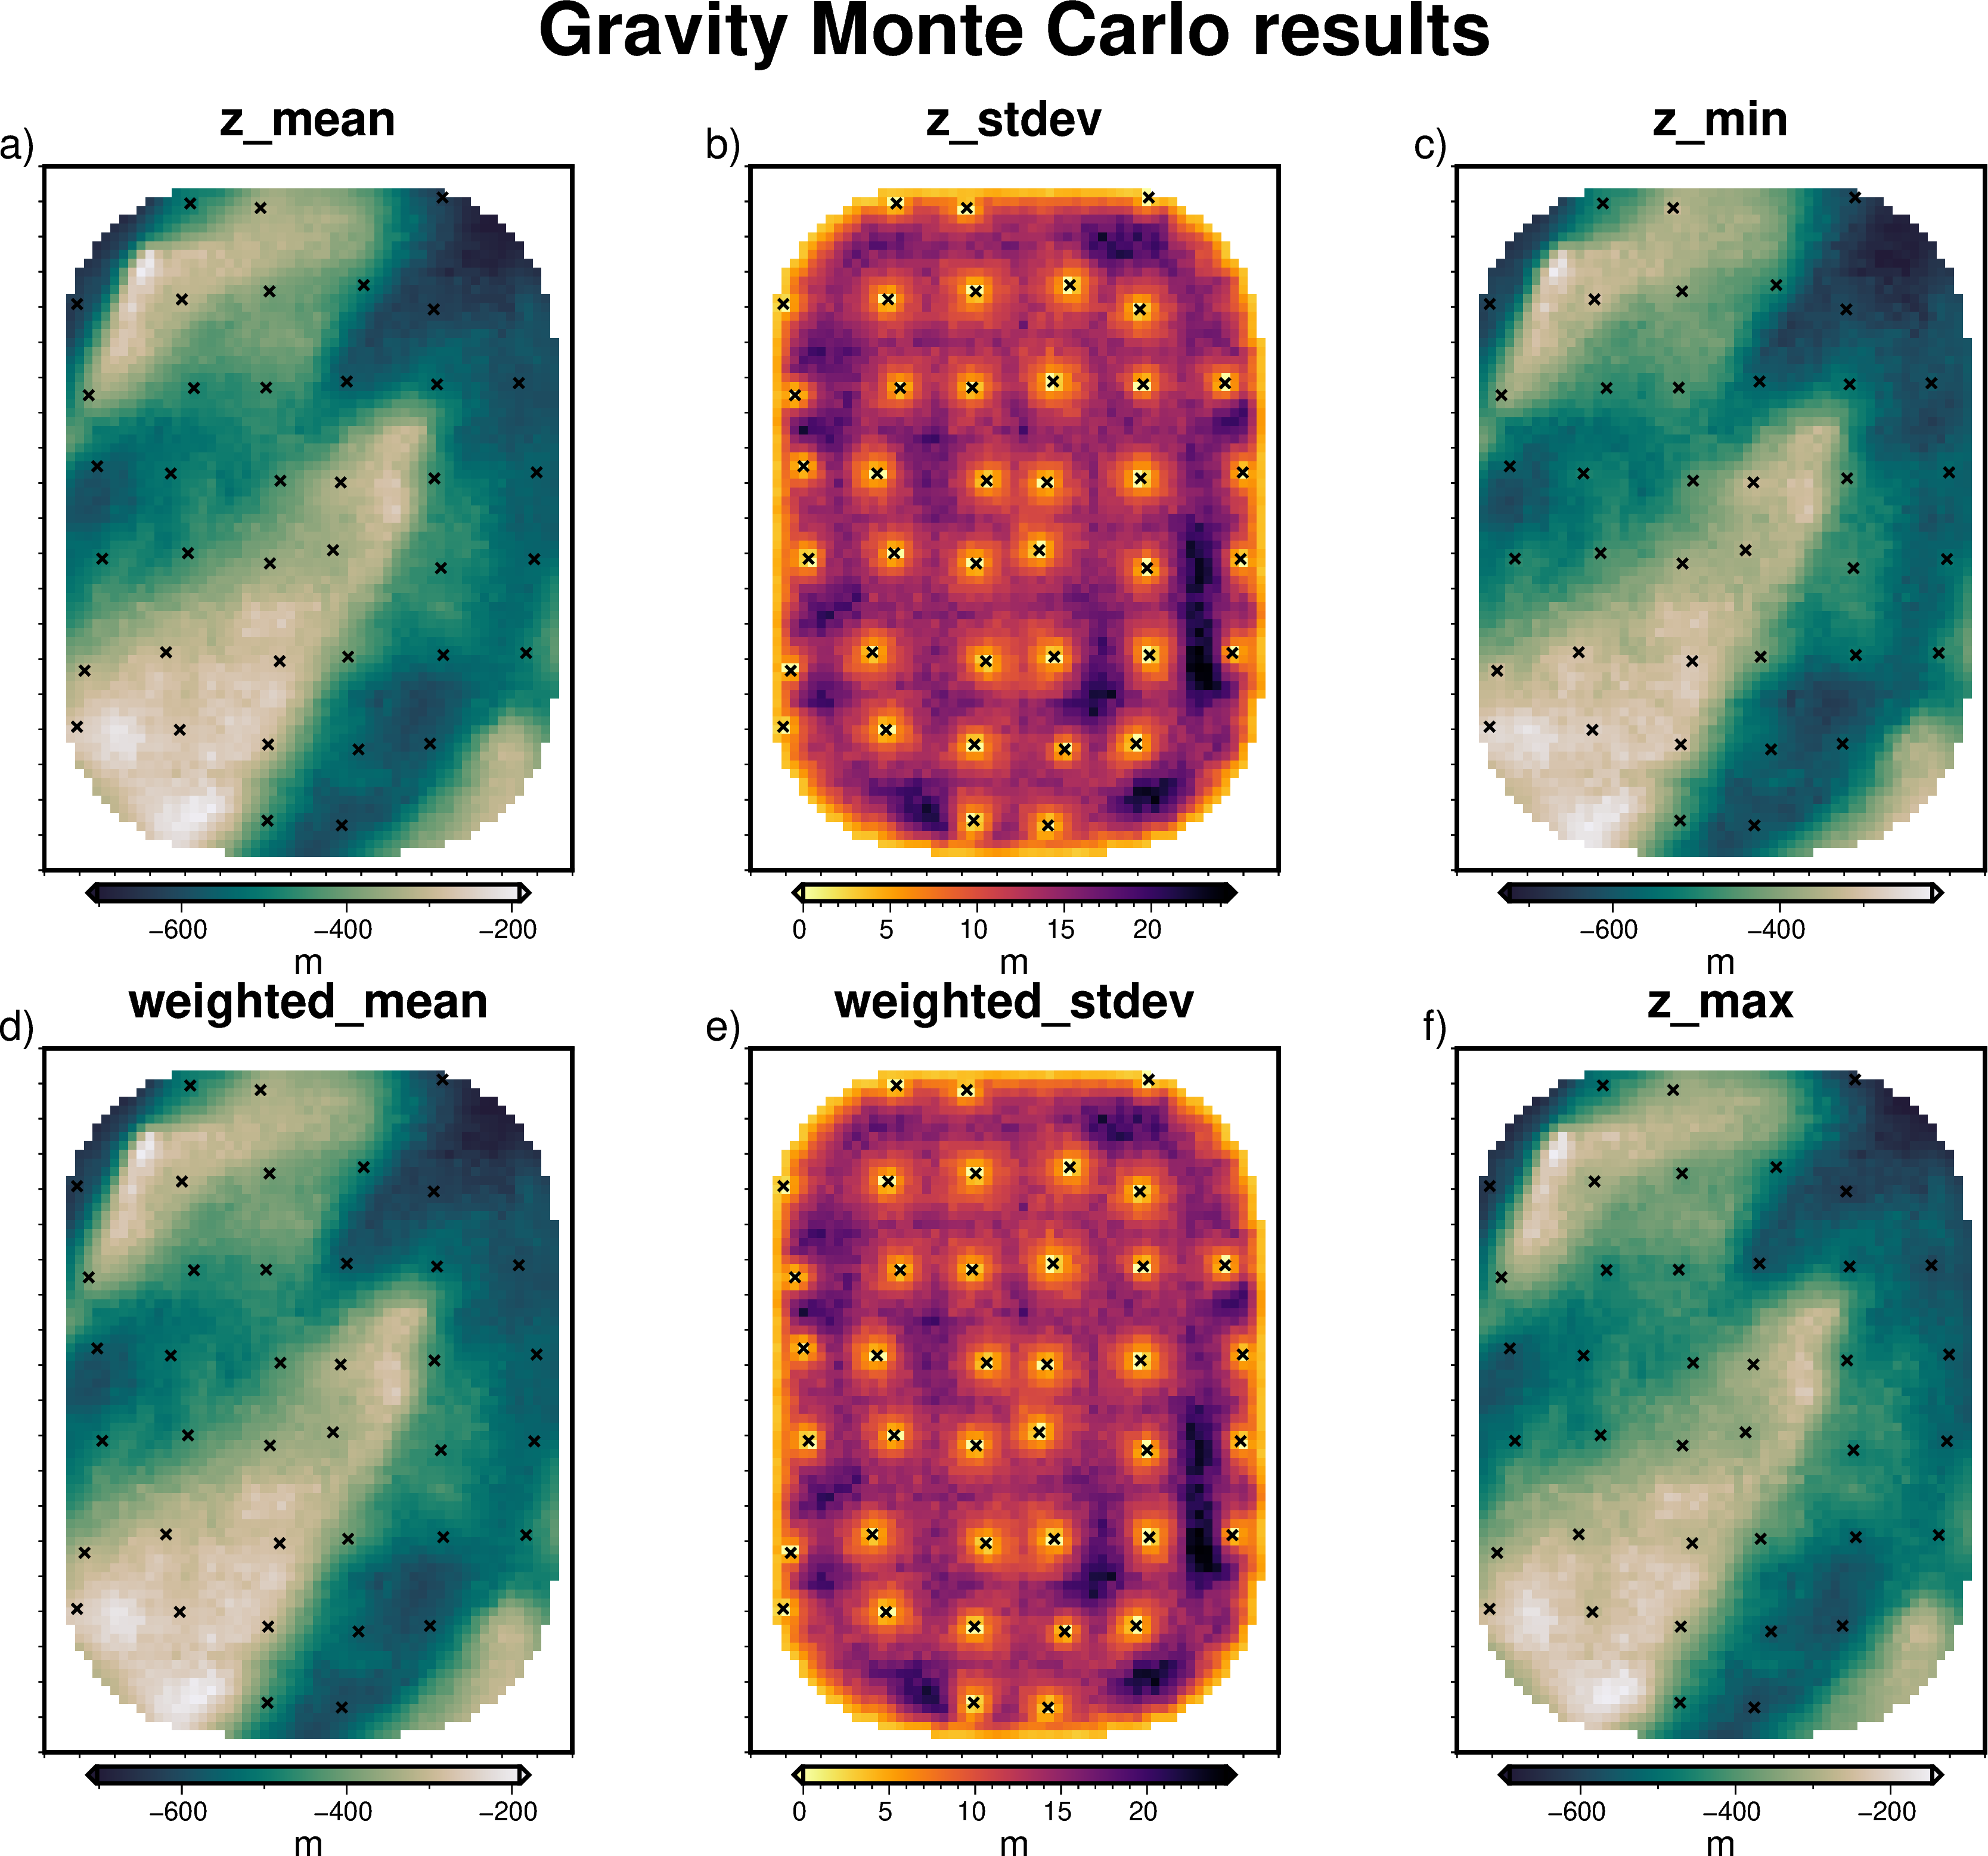

In [59]:
if plot:
    plot_stats(
        "Gravity Monte Carlo results",
        grav_dfs,
    )

## Constraints

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

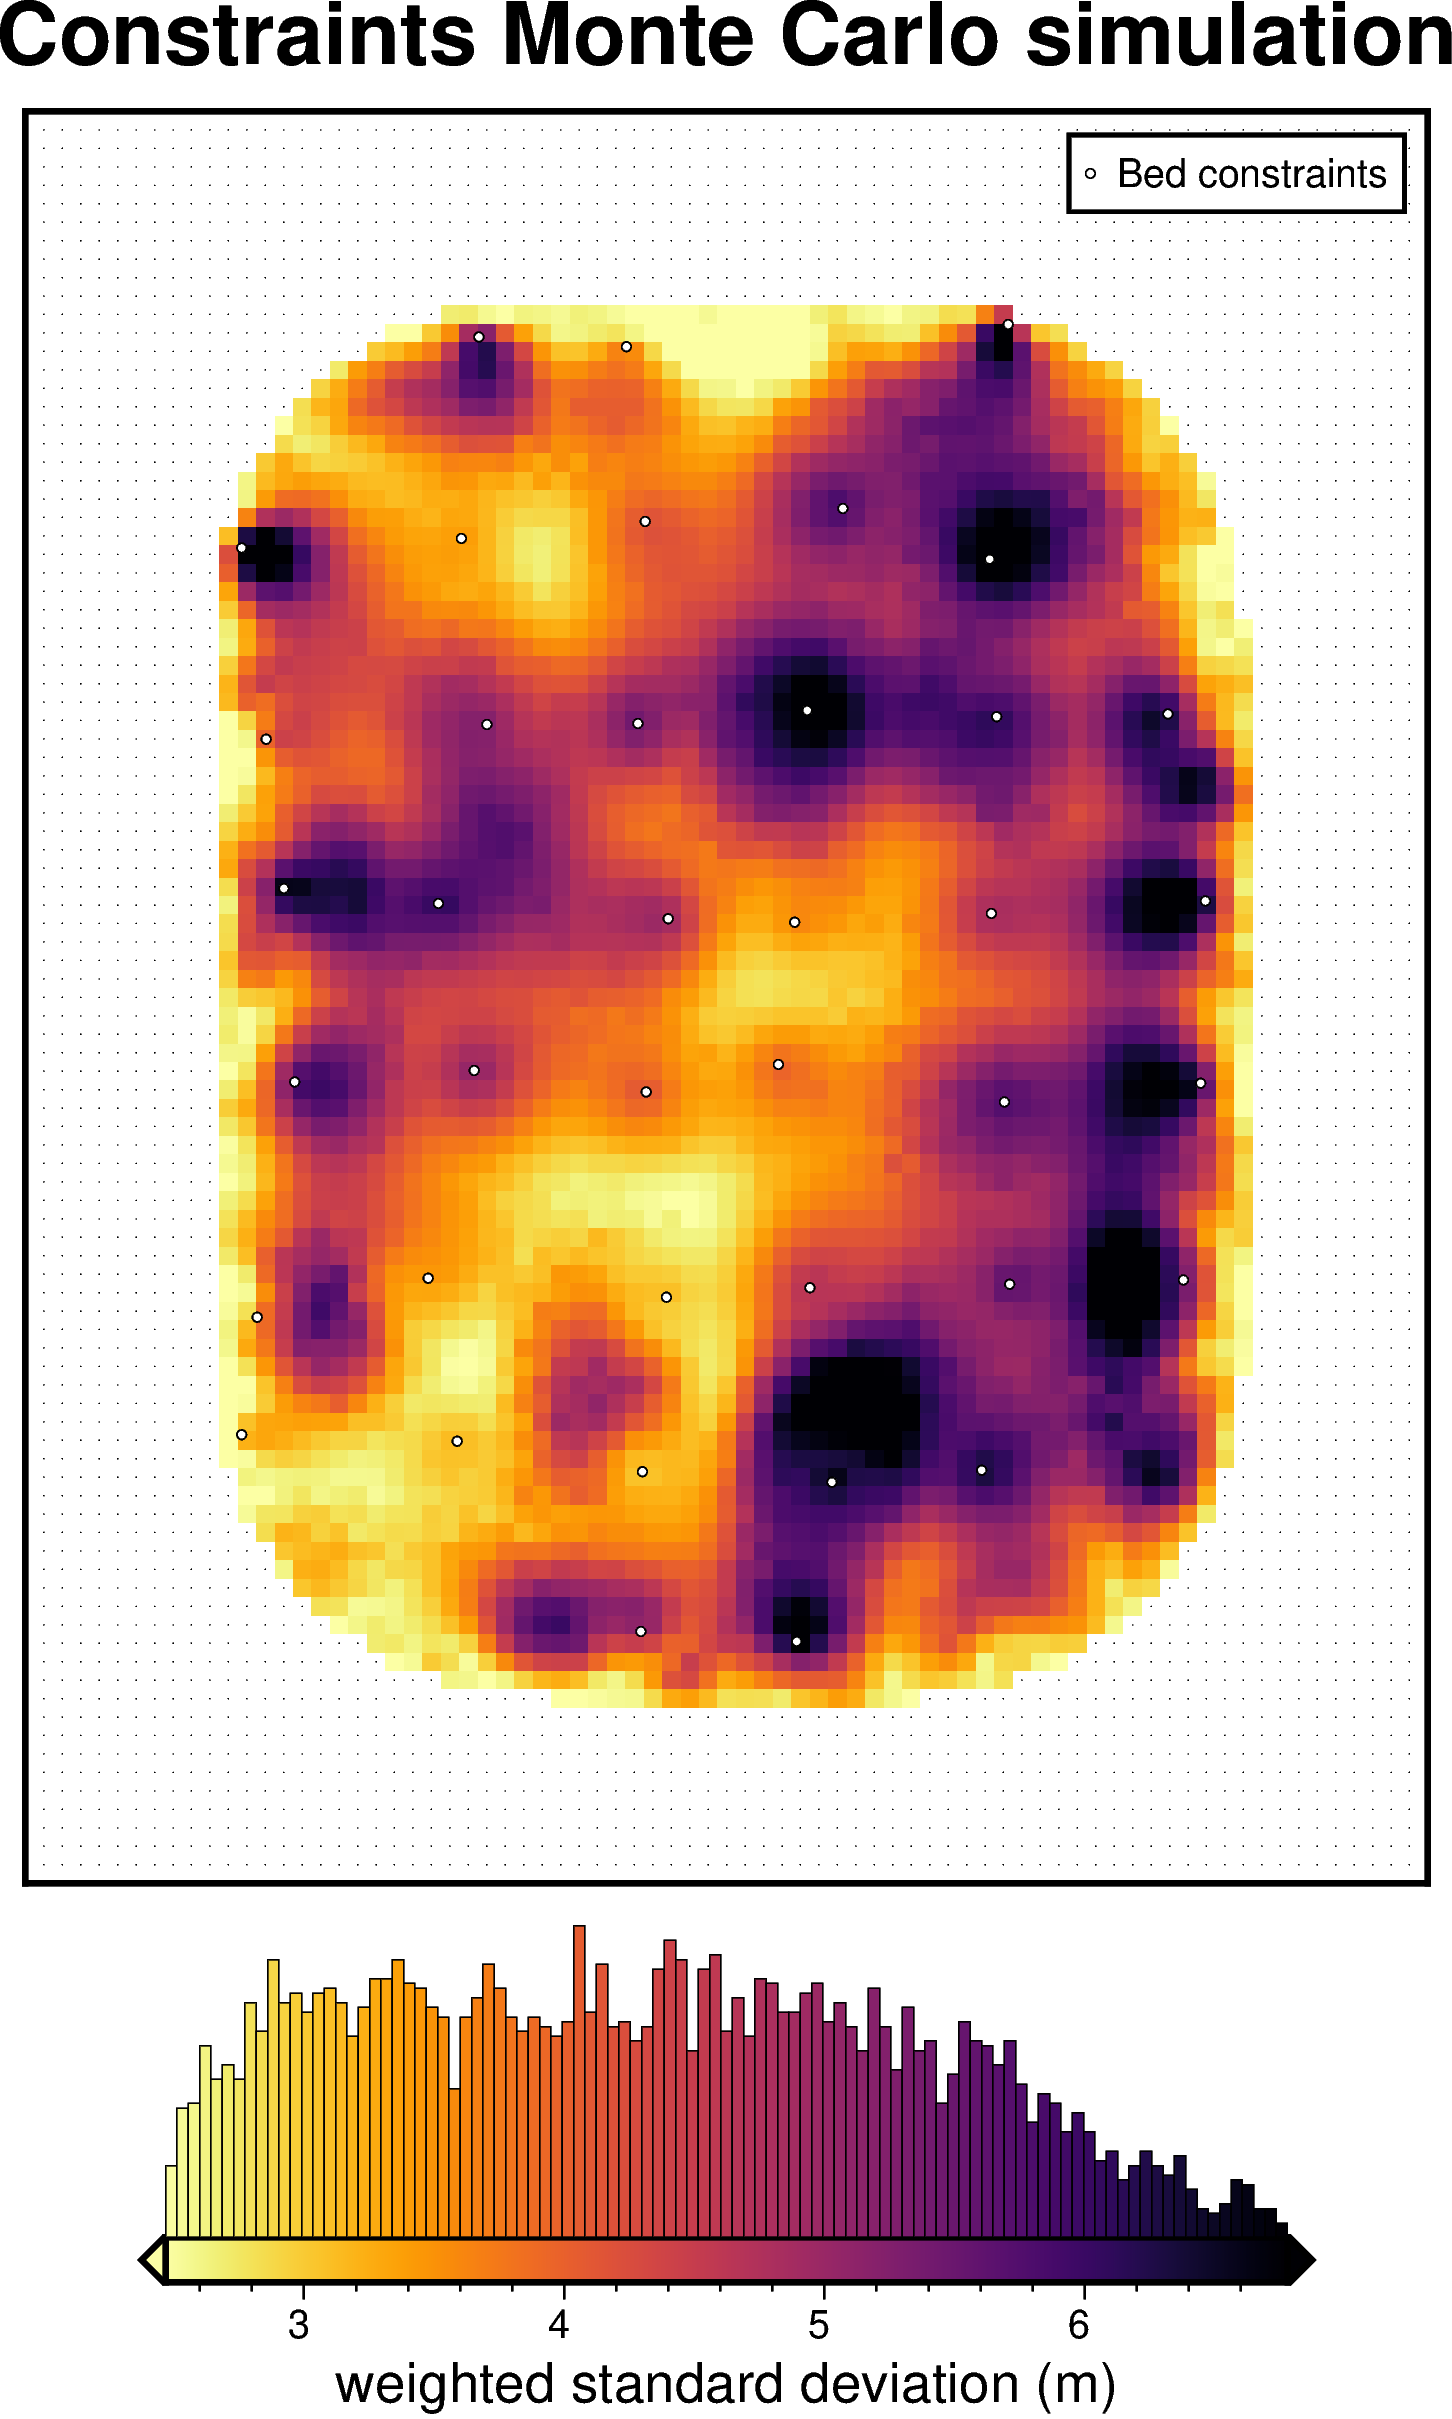

{'density_contrast': '1276 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '7 seconds', 'average_iteration_time': '0.54 seconds', 'Final misfit RMSE / L2-norm': '0.4665 /0.683 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.5278990752995014, 0.5689377328380942, 0.5161375356838107, 0.5053402753546834, 0.5018774466589093, 0.5129700740799308, 0.5386544968932867, 0.5801582224667072, 0.6052046371623874, 0.5166157251223922, 0.5185789559036493, 0.5205119699239731, 0.578029315918684, 0.5761832306161523]}
{'water_density': 1024, 'sediment_density': 2300}


In [16]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_constraints.zarr"

constraint_results = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    # sample_grav = True,             # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    # sample_water_density = True,    # will recalculate bouguer anomalies and regional field
    # sample_sediment_density = True, # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Constraints Monte Carlo simulation",
    **kwargs,
)

topos, params, values, grav_dfs = constraint_results

print(params[-1])
print(values[-1])

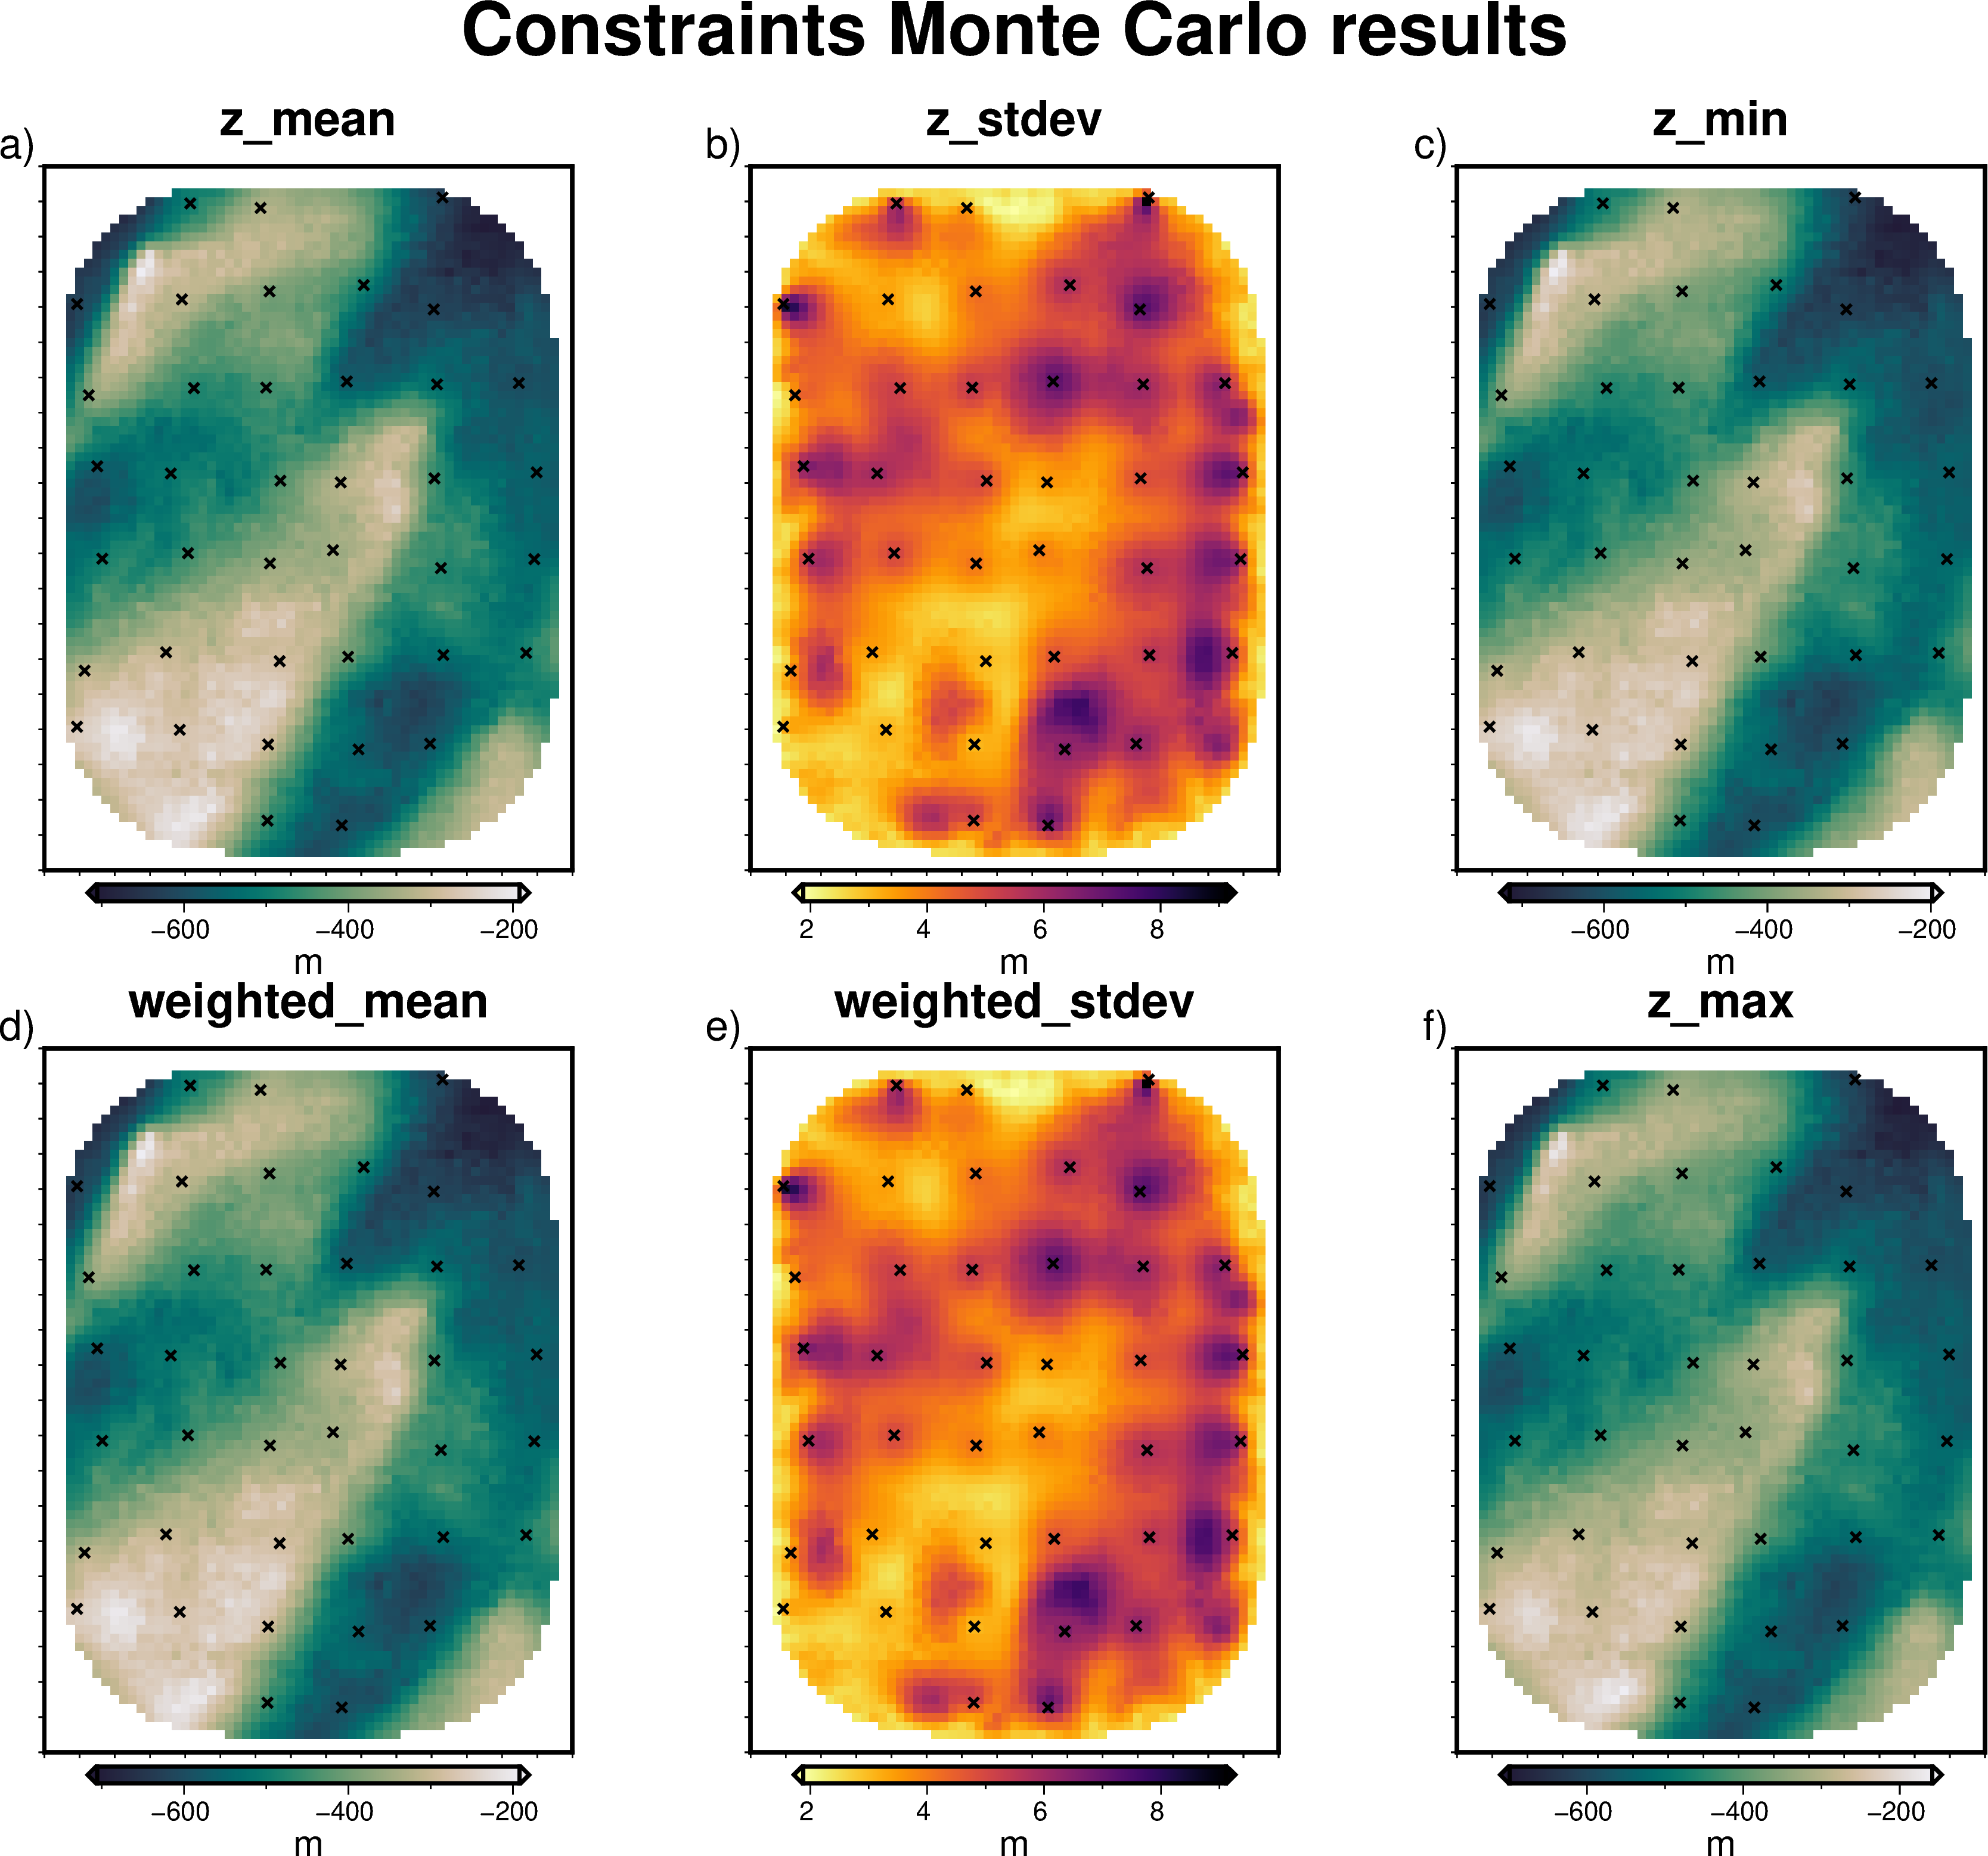

In [61]:
if plot:
    plot_stats(
        "Constraints Monte Carlo results",
        grav_dfs,
    )

## Densities

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

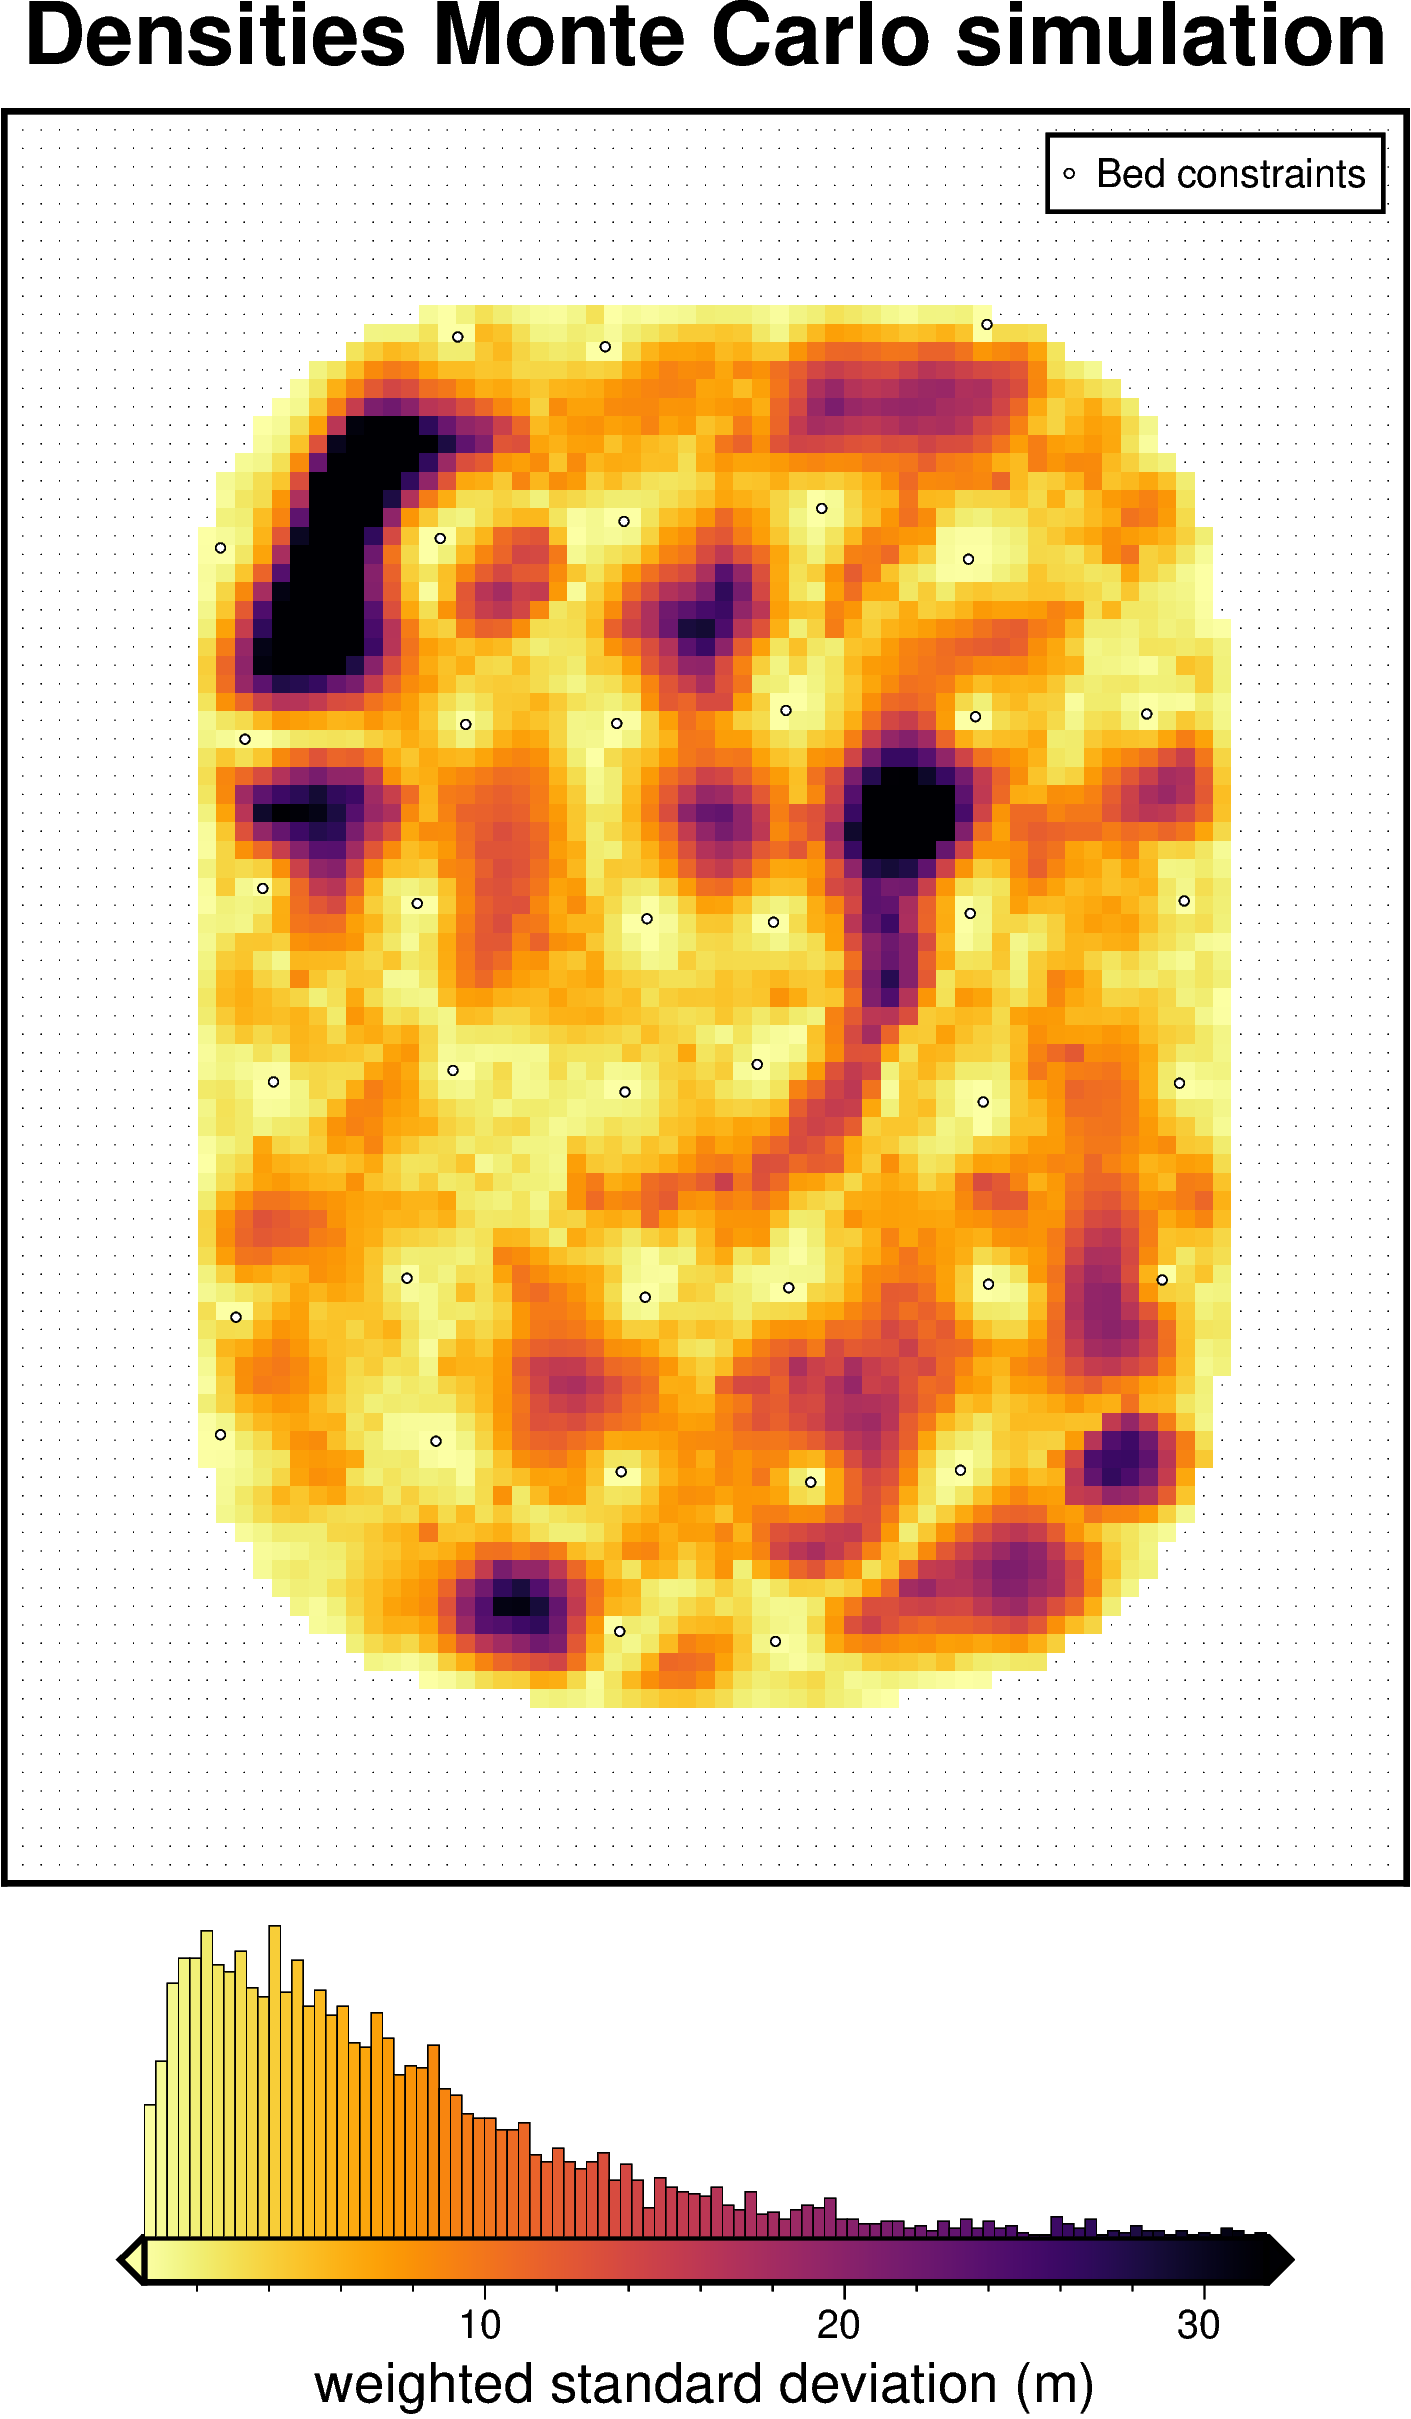

{'density_contrast': '1089.8201624968942 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '9 seconds', 'average_iteration_time': '0.55 seconds', 'Final misfit RMSE / L2-norm': '0.4678 /0.684 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.5548152634873986, 0.5059455297887325, 0.4967161128297448, 0.5203880304470658, 0.5099595310166478, 0.5448270319029689, 0.5970290740951896, 0.5590759767219424, 0.5427290638908744, 0.5177319832146168, 0.5406439295038581, 0.5533452350646257, 0.5700282836332917, 0.520323870703578, 0.6026660976931453, 0.5944280605763197, 0.6179649131372571]}
{'water_density':

In [17]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_densities.zarr"

densities_results = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    # sample_grav = True,             # will recalculate regional field
    # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field
    sample_water_density=True,  # will recalculate bouguer anomalies and regional field
    sample_sediment_density=True,  # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    # plot=True,
    mask="../data/Ross_Sea_outline.shp",
    title="Densities Monte Carlo simulation",
    **kwargs,
)

topos, params, values, grav_dfs = densities_results

print(params[-1])
print(values[-1])

# Comparing Full, Gravity, Constraints, and Densities

In [39]:
results = [
    full_results,
    grav_results,
    constraint_results,
    densities_results,
]

grids = []
for i in results:
    # get final residuals
    residuals = [utils.RMSE(df[list(df.columns)[-1]]) for df in i[3]]

    # convert residuals into weights
    weights = [1 / (x**2) for x in residuals]

    # calculated stats
    stats = inv_utils.model_ensemble_stats(i[0], weights=weights)
    merged, z_mean, z_stdev, weighted_mean, weighted_stdev, z_min, z_max = stats

    weighted_stdev = utils.mask_from_shp(
        shapefile="../data/Ross_Sea_outline.shp",
        xr_grid=weighted_stdev,
        masked=True,
        invert=False,
    )
    grids.append(weighted_stdev)

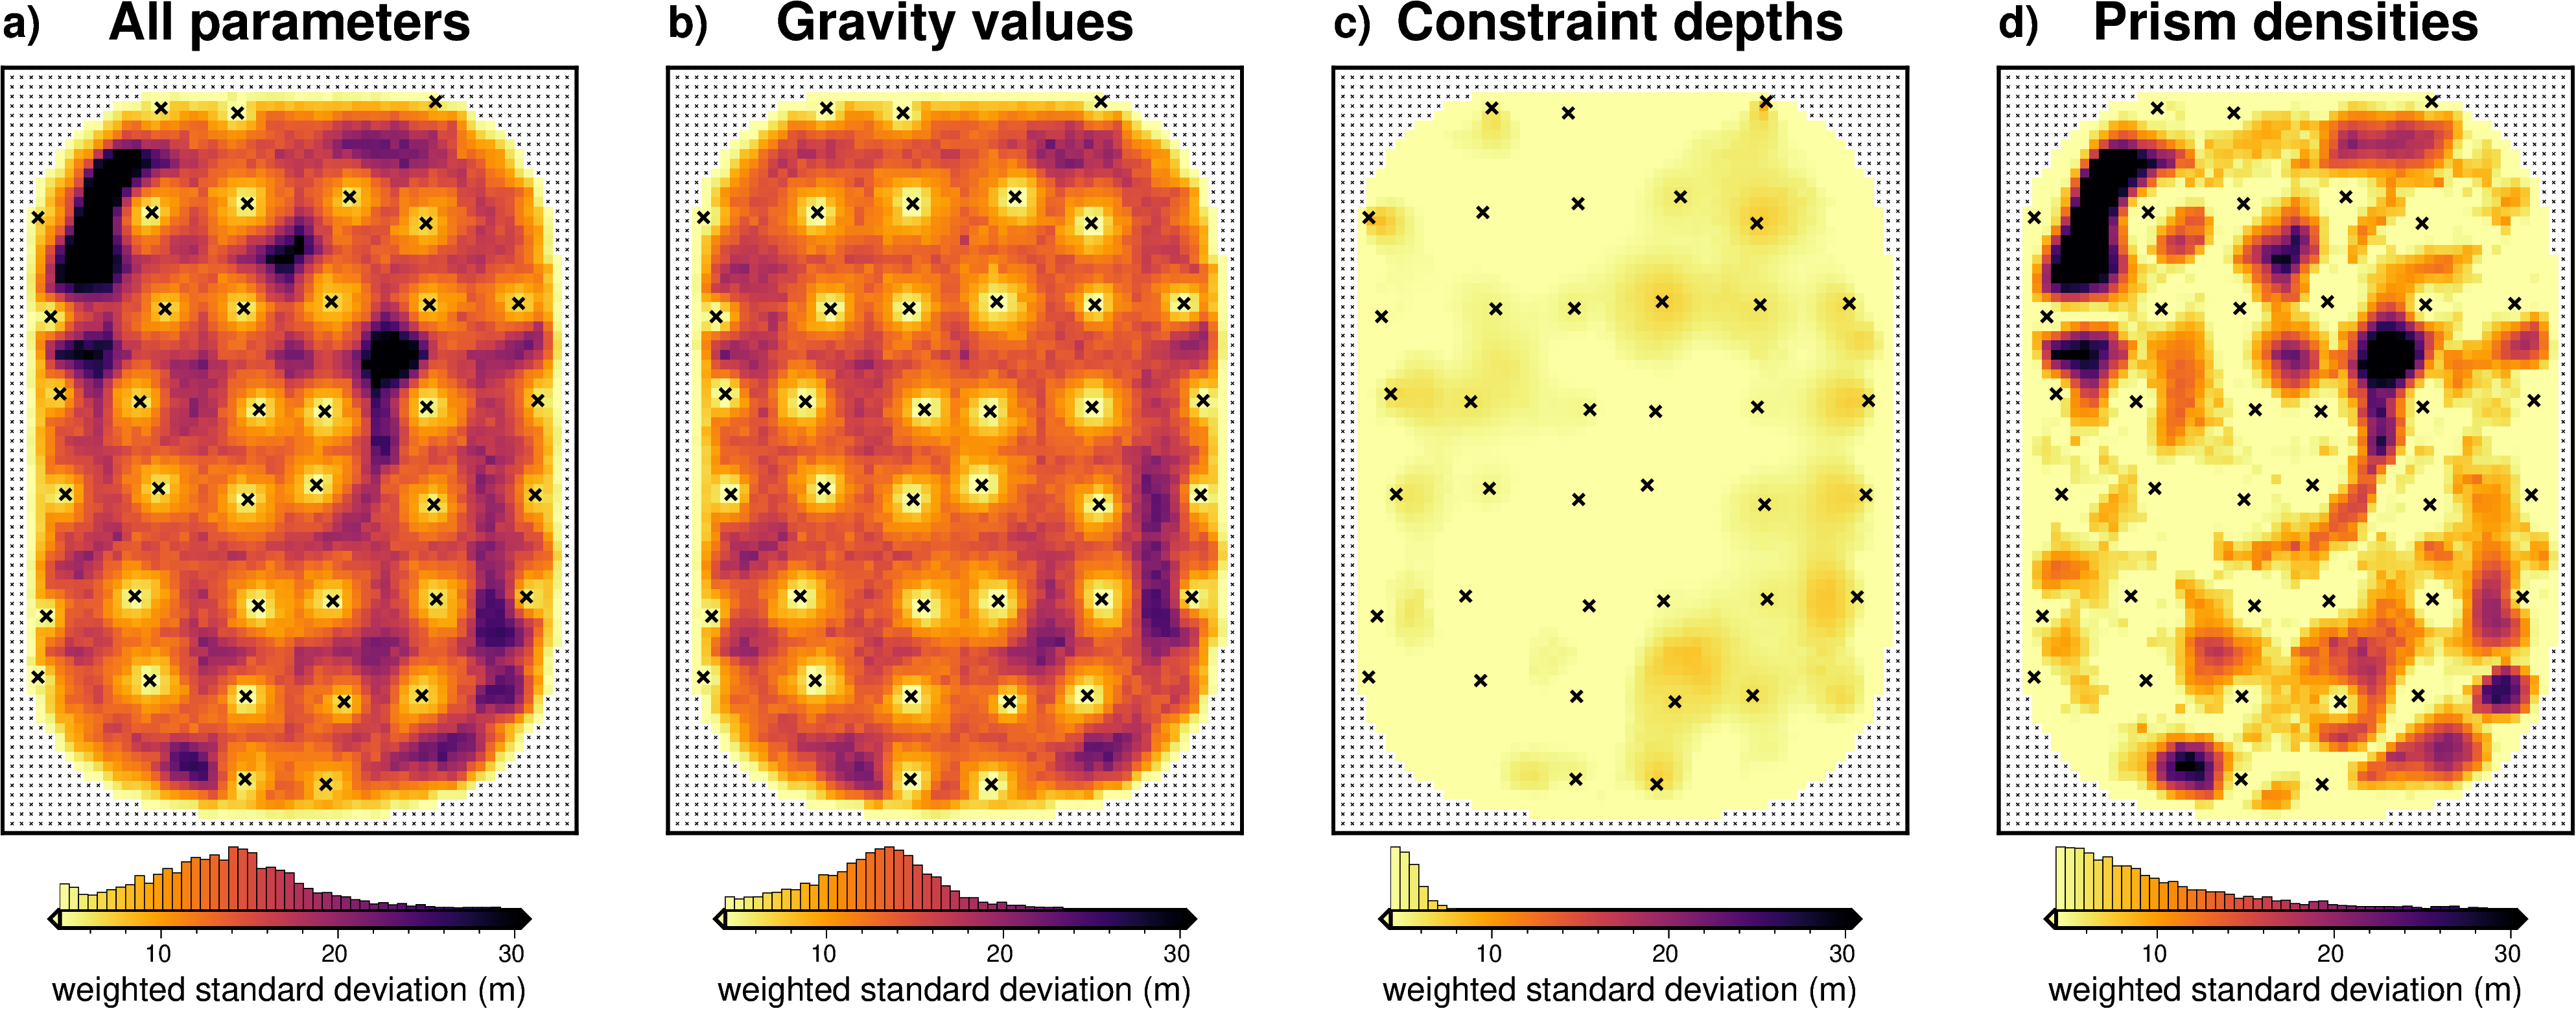

In [52]:
import string

# set color limits
lims = utils.get_min_max(
    grids[0],
    robust=True,
)

titles = [
    "All parameters",
    "Gravity values",
    "Constraint depths",
    "Prism densities",
]

for i, g in enumerate(grids):
    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = None
        yshift_amount = None
    # elif i == 2:
    #     fig = fig
    #     origin_shift = "both_shift"
    #     xshift_amount = -1.1
    #     yshift_amount = -1
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1.1
        yshift_amount = None

    fig = maps.plot_grd(
        g,
        region=inversion_region,
        title=titles[i],
        # title_font = "12p,Helvetica,black",
        cbar_label="weighted standard deviation (m)",
        fig_height=10,
        cmap="inferno",
        reverse_cpt=True,
        cpt_lims=lims,
        points=constraints[constraints.inside].rename(
            columns={"easting": "x", "northing": "y"}
        ),
        points_style="x.2c",
        points_pen="1.2p",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
    )

    fig.text(
        position="TL",
        justify="BL",
        text=f"{string.ascii_lowercase[i]})",
        font="16p,Helvetica-Bold,black",
        offset="j0c/.4c",
        no_clip=True,
    )
    fig.plot(
        x=constraints[constraints.inside == False].easting,
        y=constraints[constraints.inside == False].northing,
        style="x.05c",
    )
fig.show()

## Water Density

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

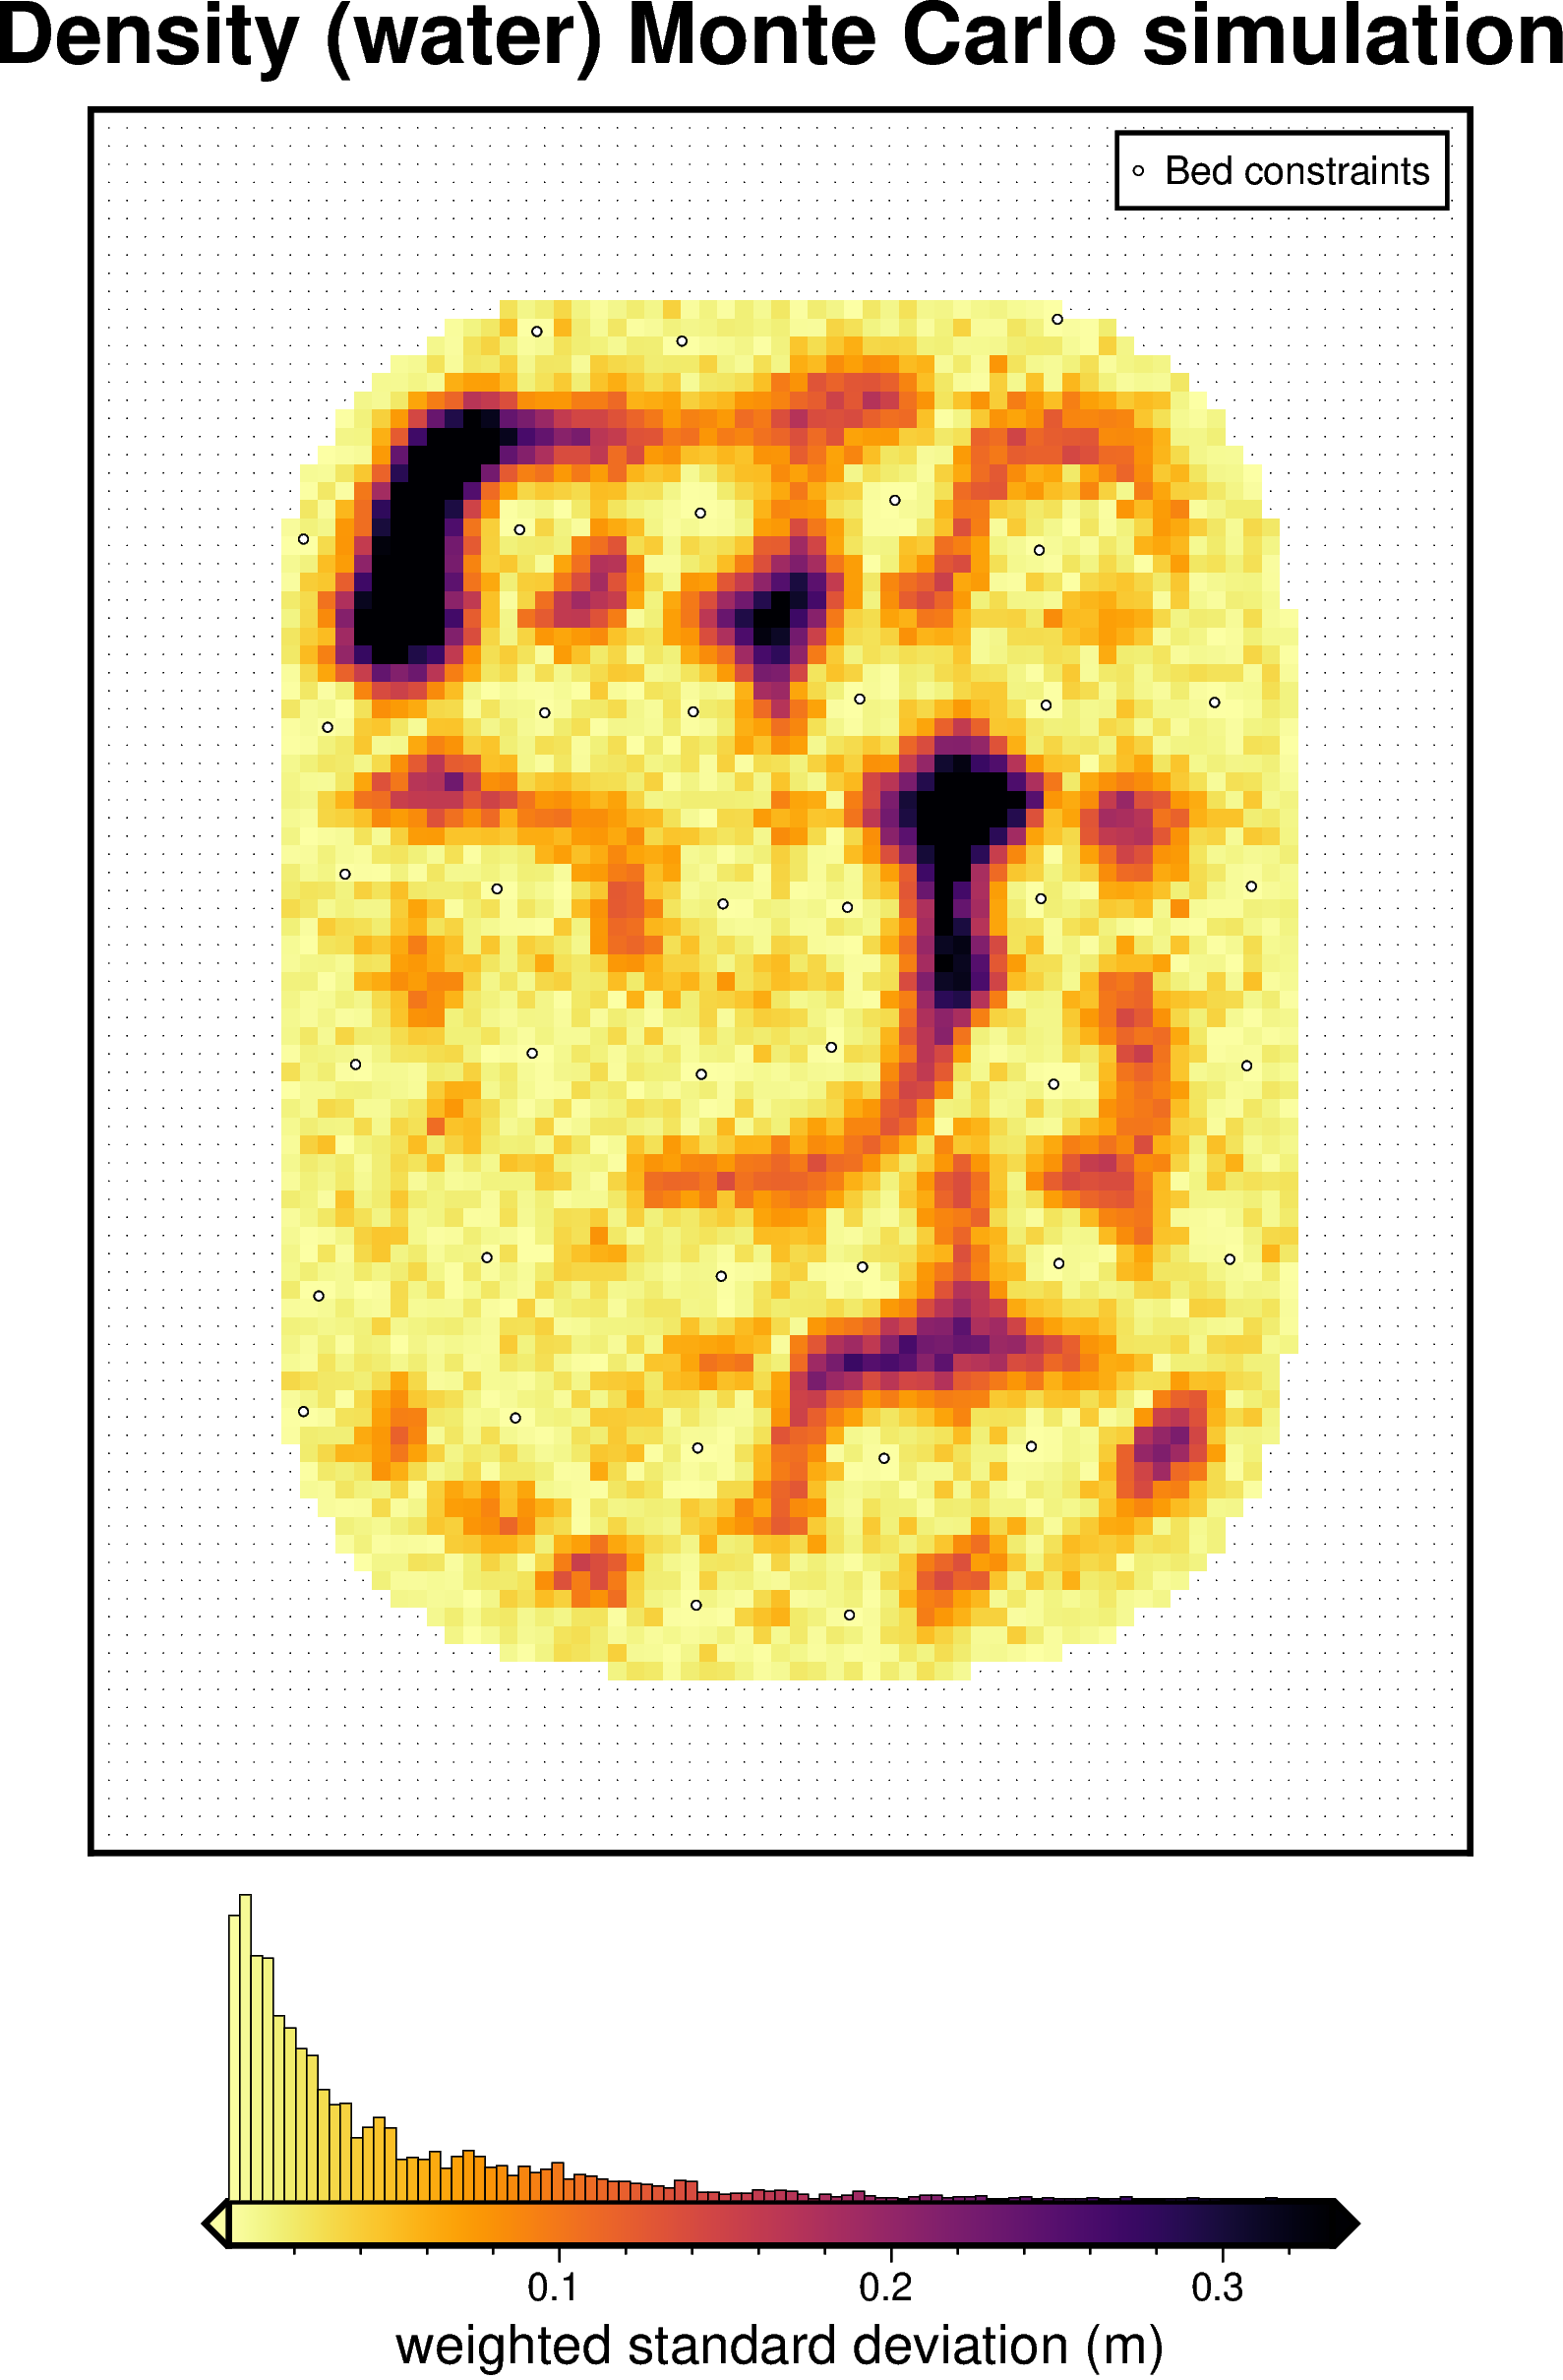

{'density_contrast': '1275.5875284785816 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '8 seconds', 'average_iteration_time': '0.54 seconds', 'Final misfit RMSE / L2-norm': '0.4277 /0.654 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.4994014501571655, 0.48722090292721987, 0.5352443037554622, 0.5558171942830086, 0.5518488986417651, 0.5370312221348286, 0.5468274429440498, 0.5123725617304444, 0.5106515120714903, 0.5859089875593781, 0.5648971078917384, 0.5623665880411863, 0.5234663542360067, 0.5243226792663336, 0.5350415306165814]}
{'water_density': 1024.4124715214184, 'sediment_density

In [62]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_water_density.zarr"

topos, params, values, grav_dfs = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    # sample_grav = True,             # will recalculate regional field
    # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field
    sample_water_density=True,  # will recalculate bouguer anomalies and regional field
    # sample_sediment_density = True, # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Density (water) Monte Carlo simulation",
    **kwargs,
)
print(params[-1])
print(values[-1])

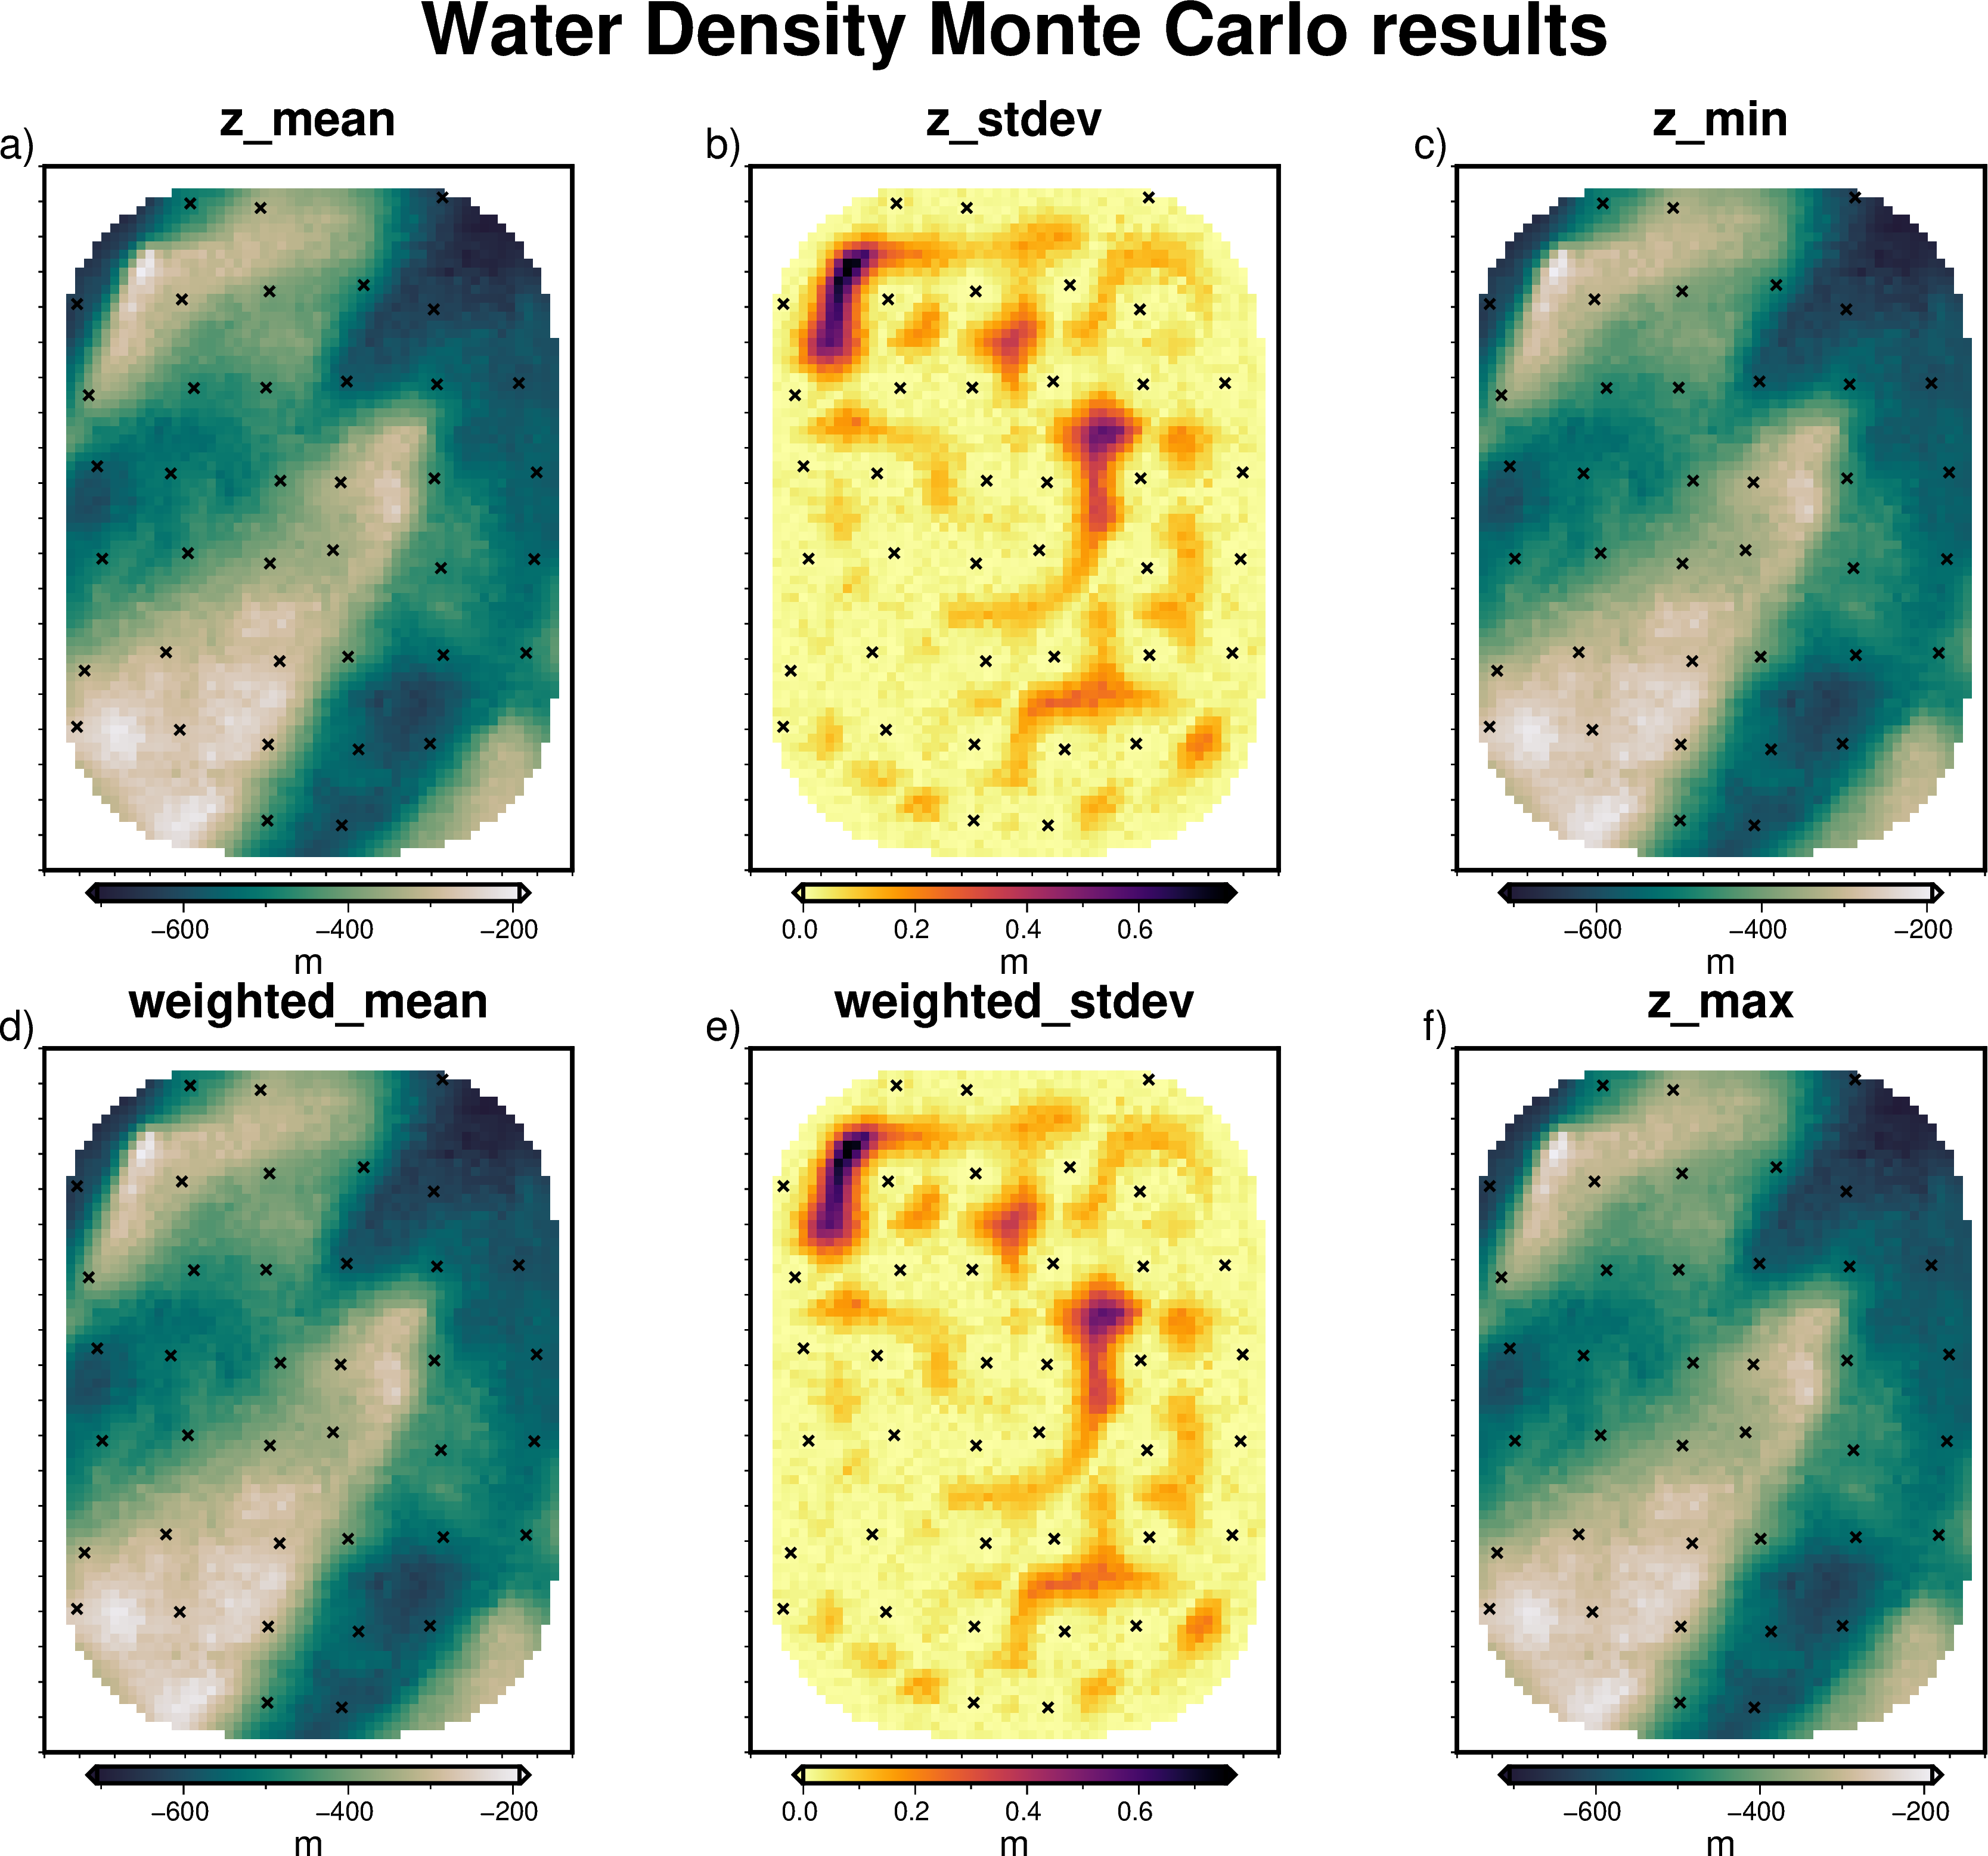

In [63]:
if plot:
    plot_stats(
        "Water Density Monte Carlo results",
        grav_dfs,
    )

## Sediment density

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

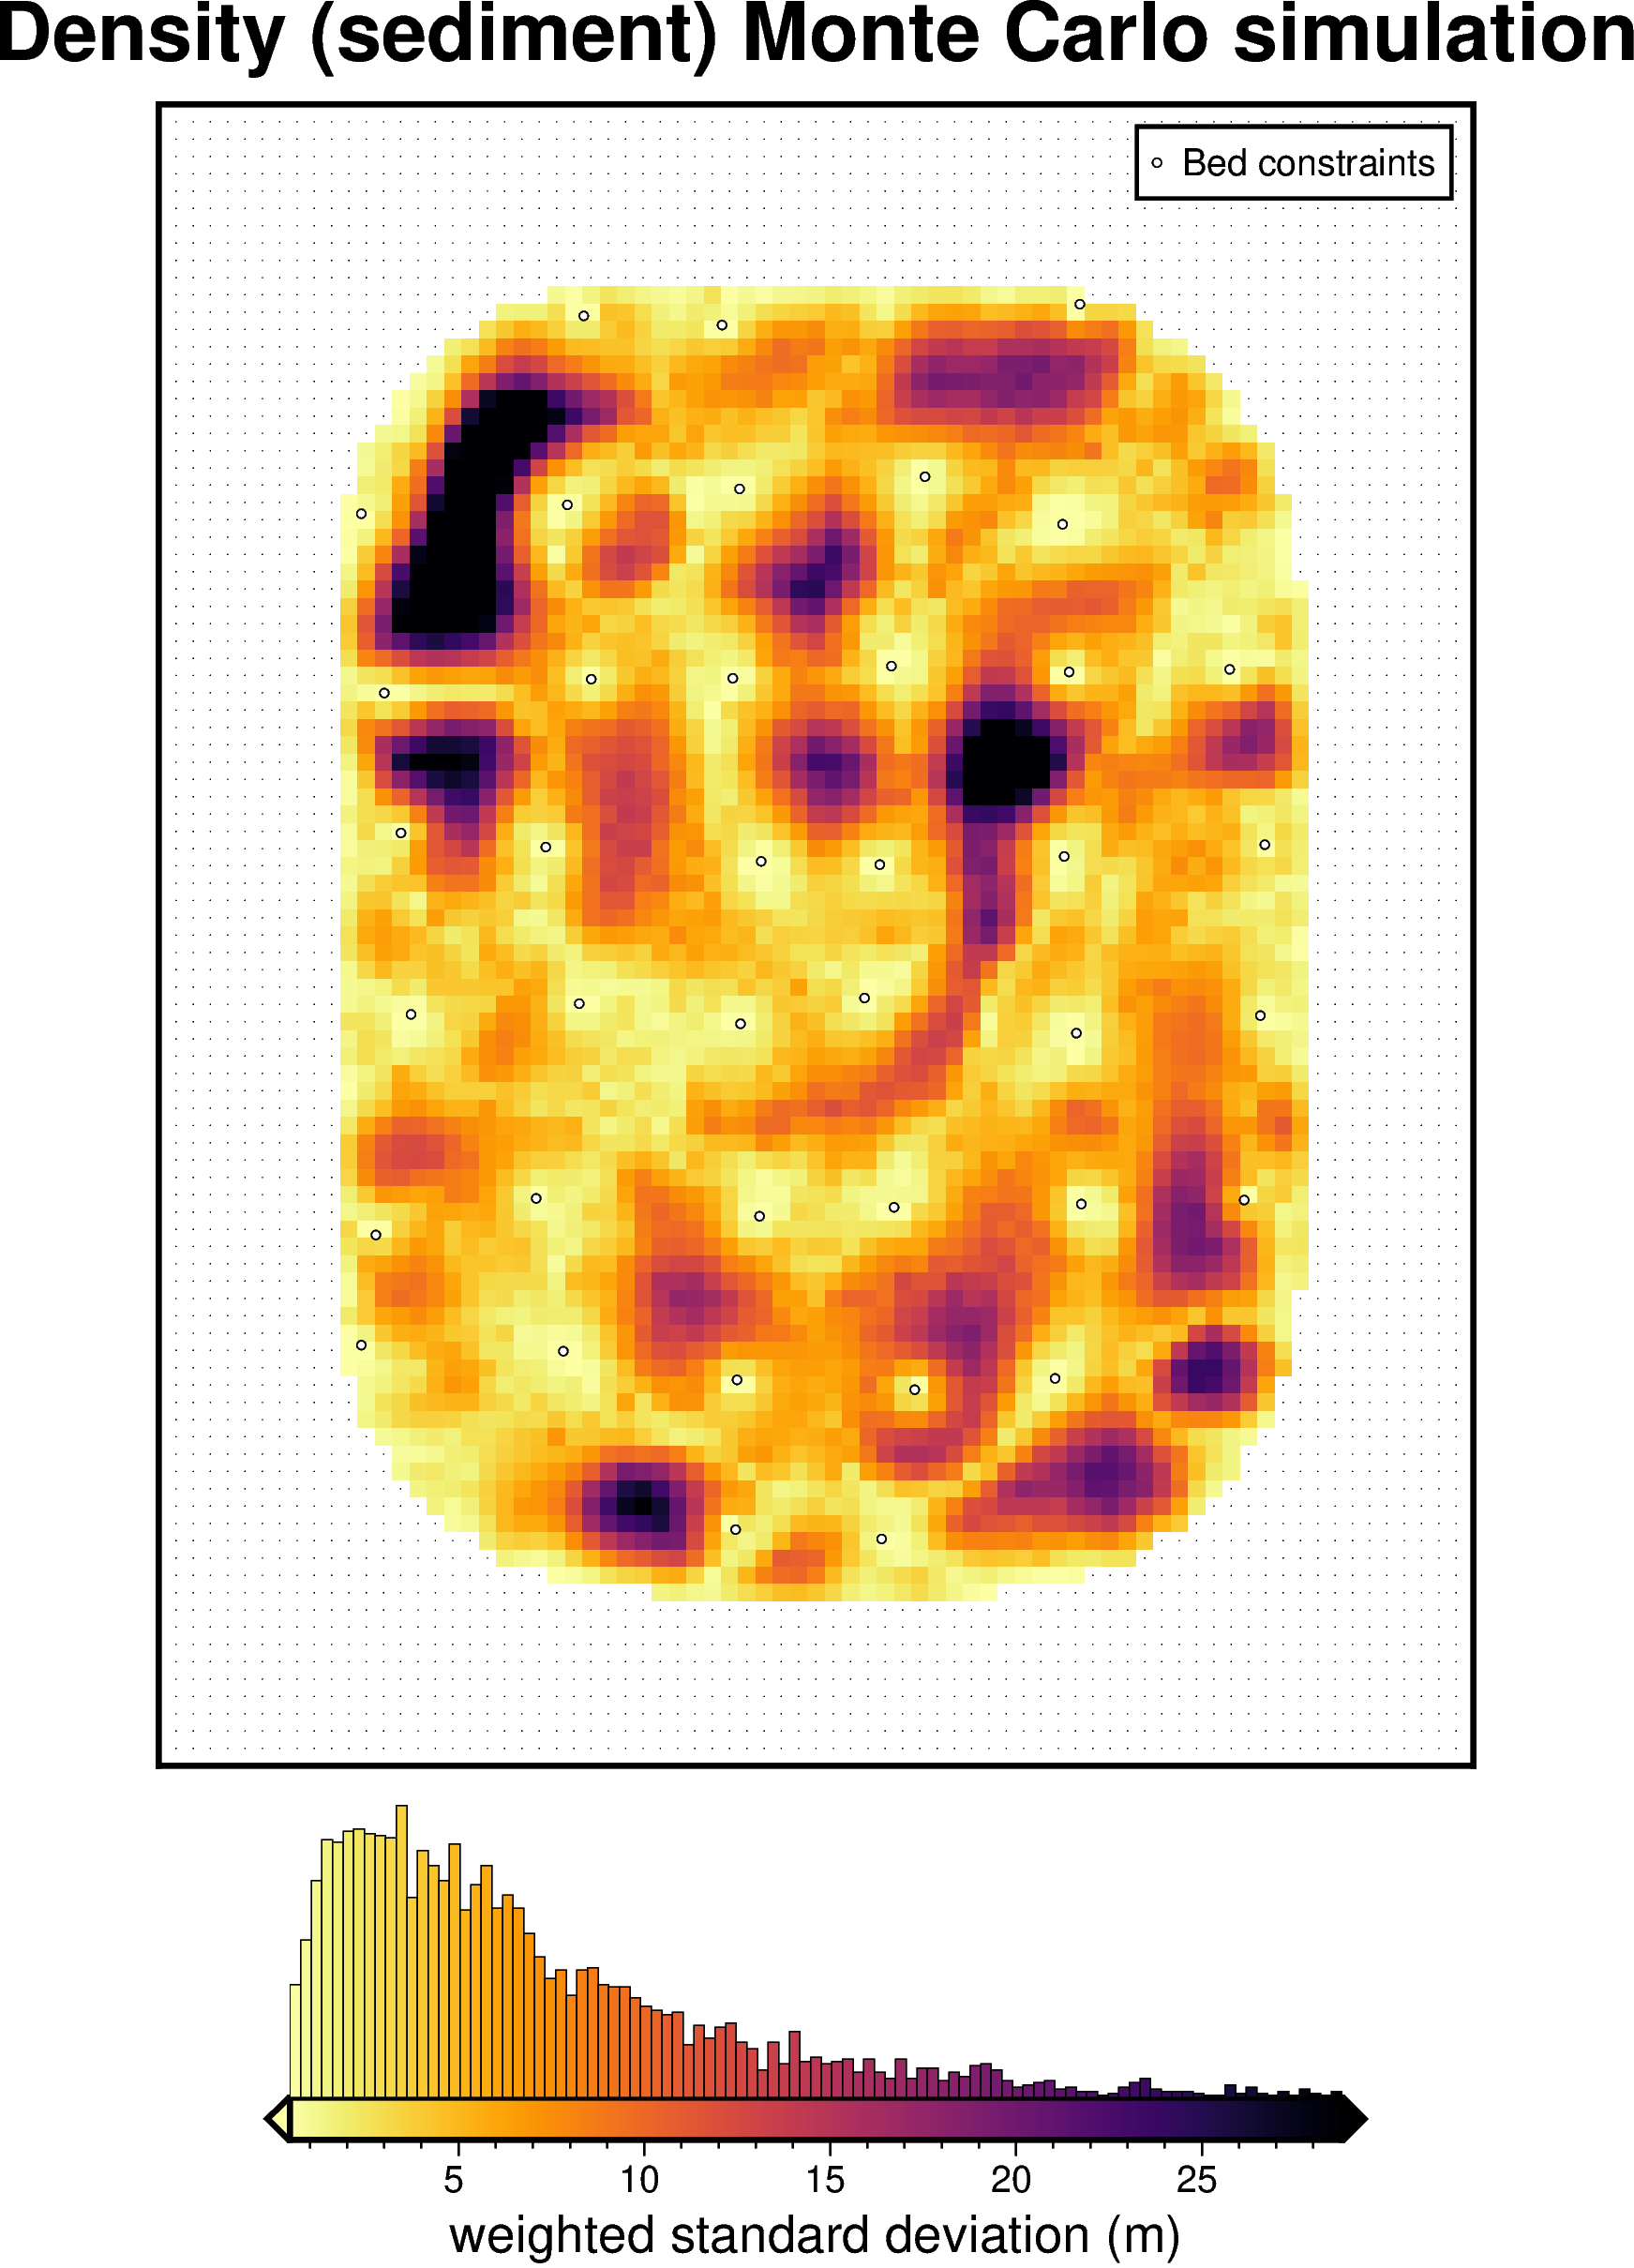

{'density_contrast': '1308.997721713481 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '7 seconds', 'average_iteration_time': '0.54 seconds', 'Final misfit RMSE / L2-norm': '0.432 /0.6573 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.49684946052730083, 0.5318076070398092, 0.5564598012715578, 0.5321780694648623, 0.504794486798346, 0.5082696657627821, 0.5170730846002698, 0.5702525302767754, 0.6706339688971639, 0.5215324452146888, 0.5228941114619374, 0.5326202446594834, 0.5332780024036765, 0.5784588782116771]}
{'water_density': 1024, 'sediment_density': 2332.997721713481}


In [64]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_sediment_density.zarr"

topos, params, values, grav_dfs = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    # sample_grav = True,             # will recalculate regional field
    # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field
    # sample_water_density = True,    # will recalculate bouguer anomalies and regional field
    sample_sediment_density=True,  # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Density (sediment) Monte Carlo simulation",
    **kwargs,
)
print(params[-1])
print(values[-1])

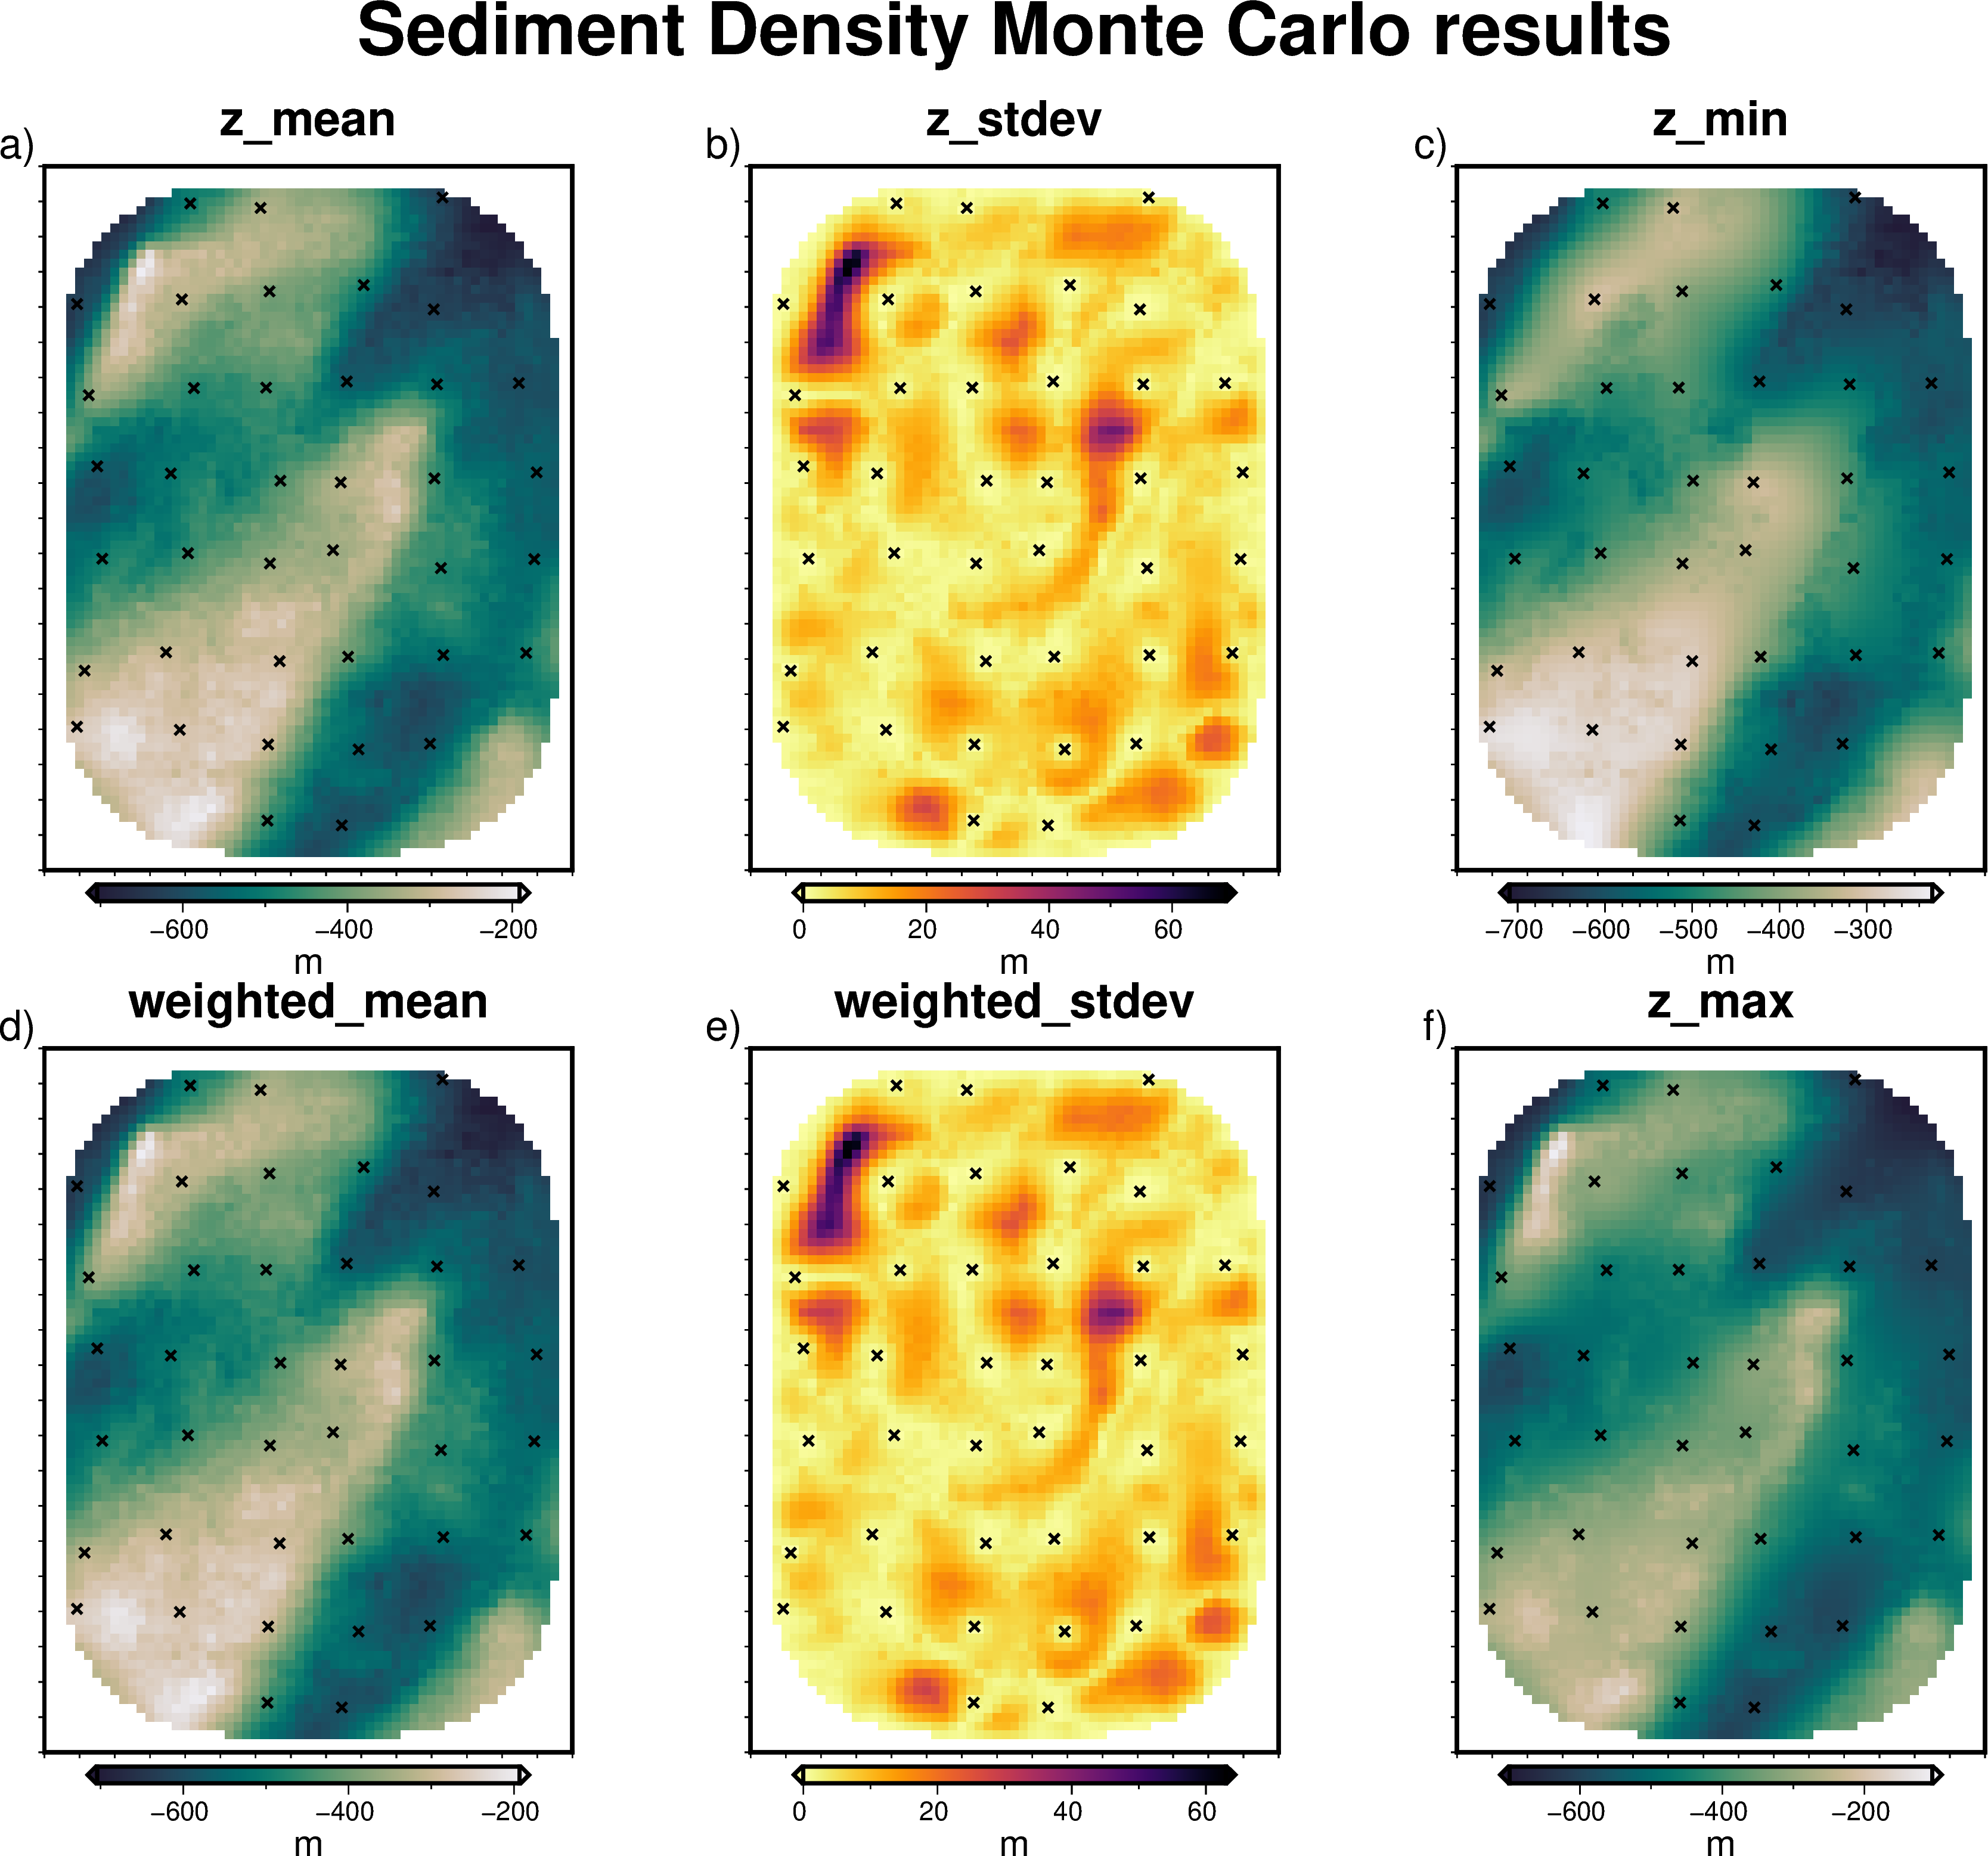

In [65]:
if plot:
    plot_stats(
        "Sediment Density Monte Carlo results",
        grav_dfs,
    )

## Data (gravity, constraints)

all 100 runs already complete, loading results from file.


0it [00:00, ?it/s]

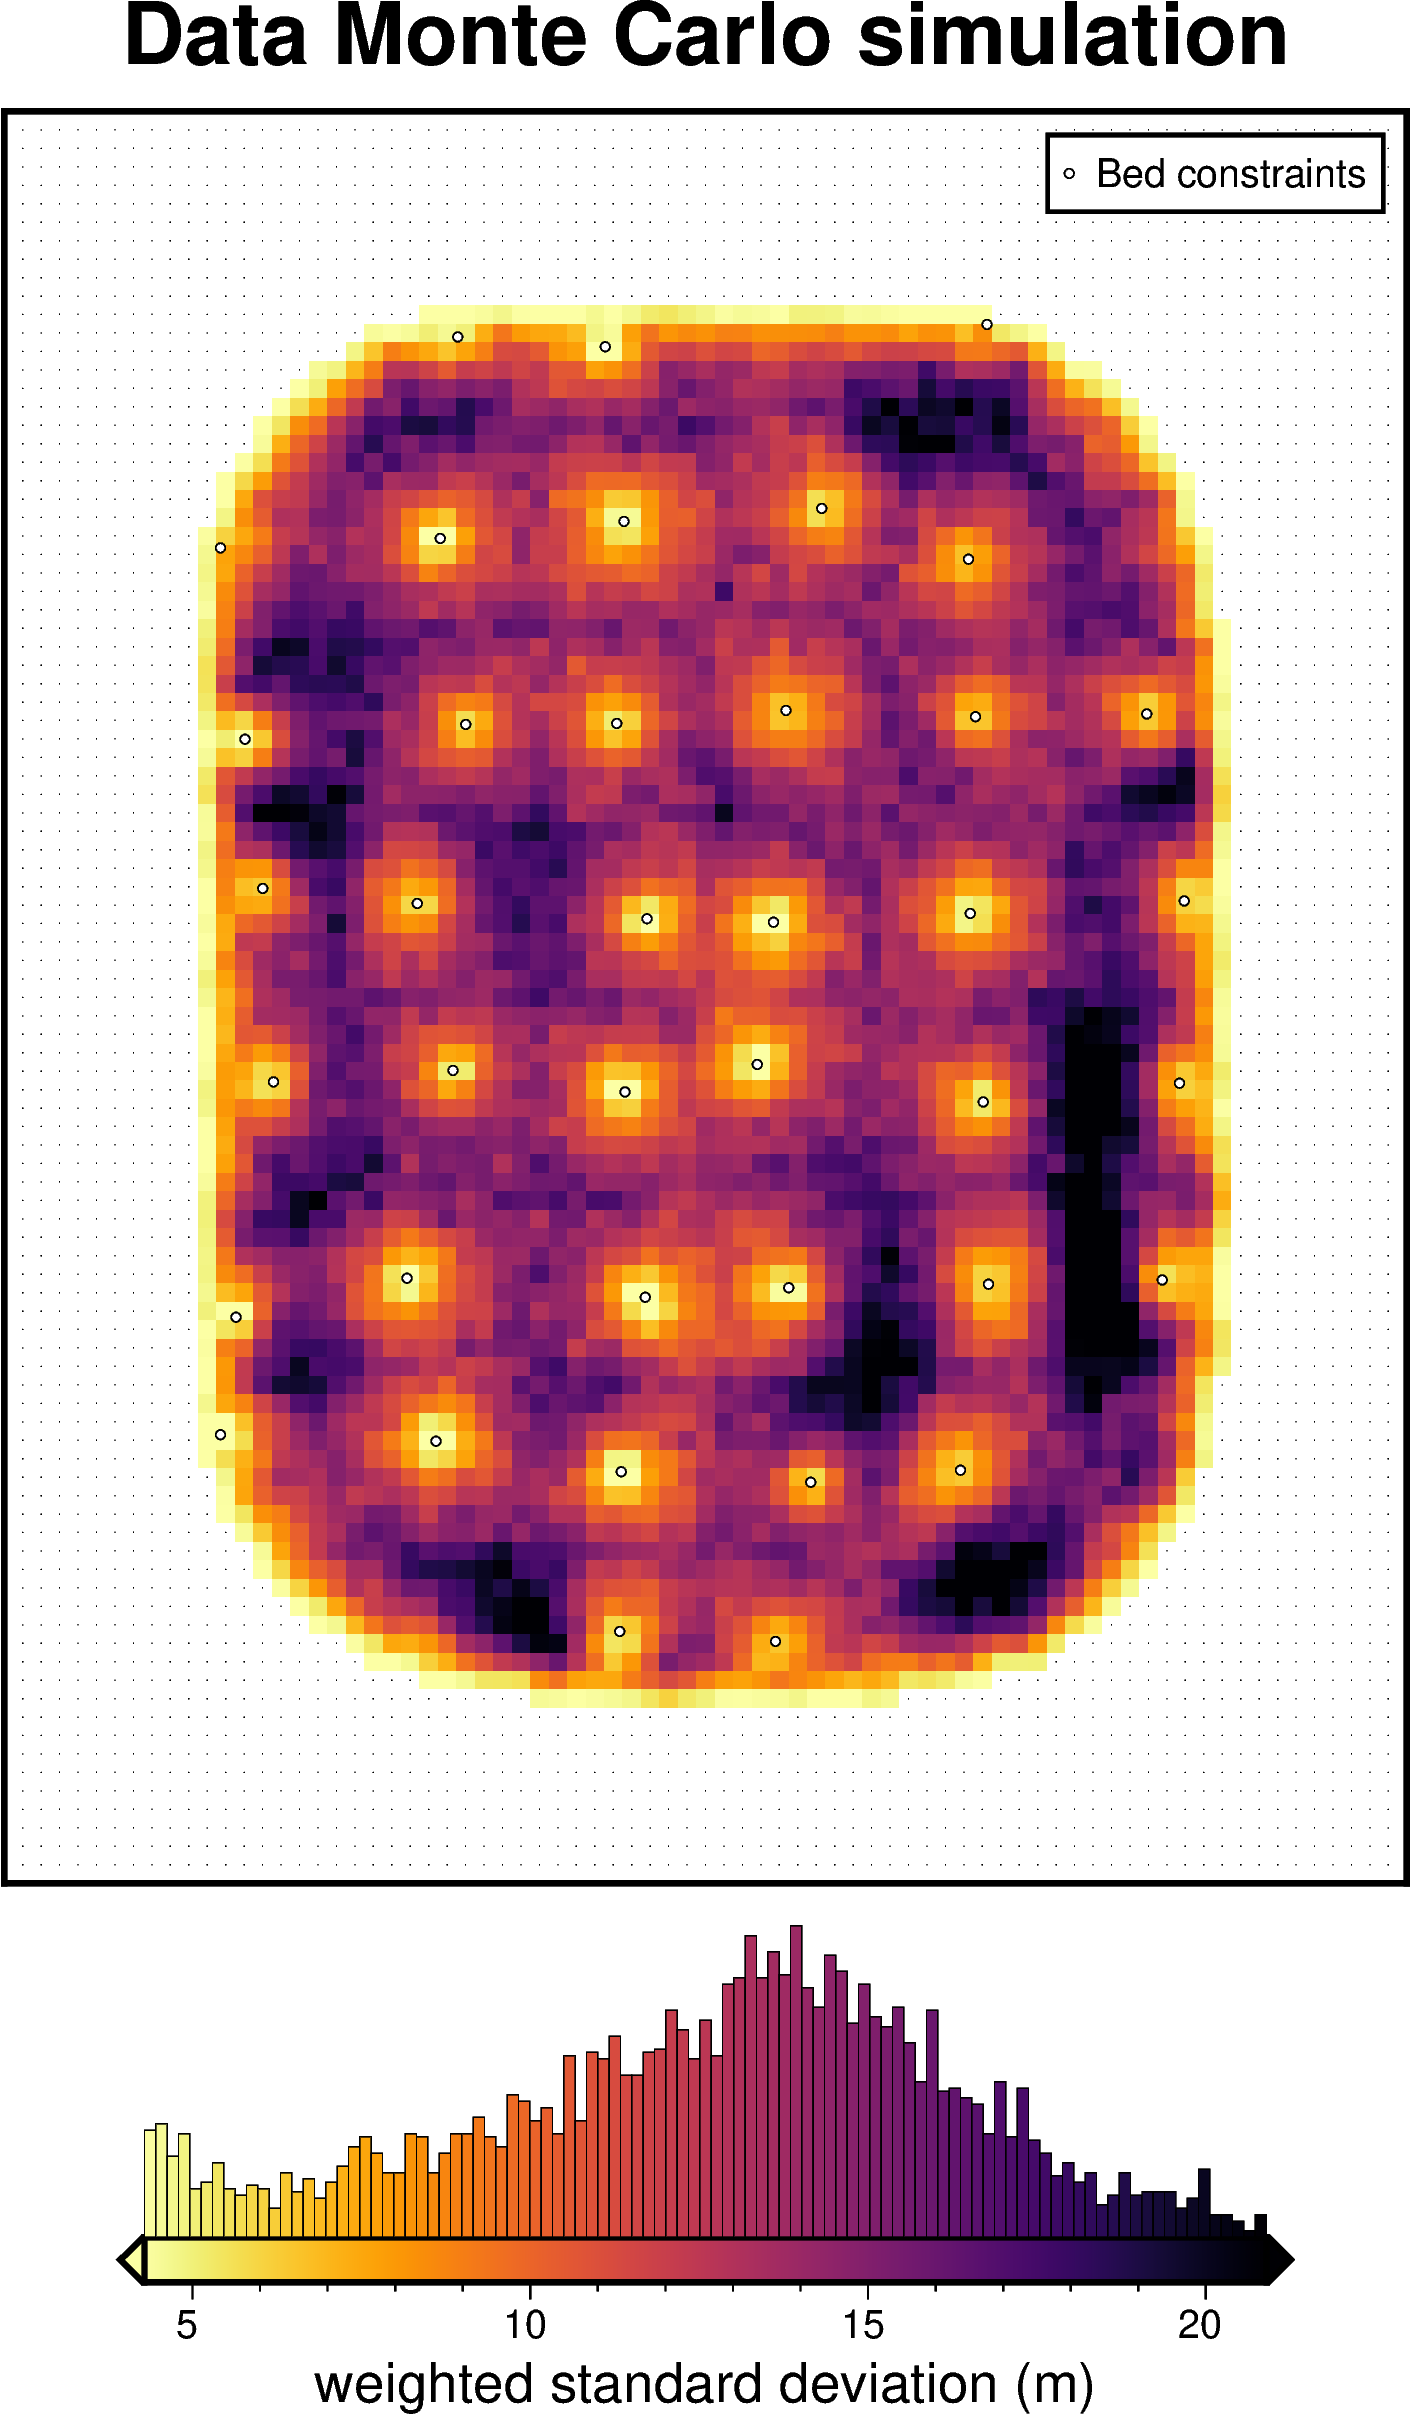

{'density_contrast': '1276 kg/m3', 'max_iterations': 100, 'l2_norm_tolerance': '0.15', 'delta_l2_norm_tolerance': '1.02', 'jacobian weights': 'Not enabled', 'deriv_type': 'annulus', 'jacobian_prism_size': '1 m', 'solver_type': 'scipy least squares', 'solver_damping': 0.06309573444801936, 'solver_weights': 'Not enabled', 'upper_confining_layer': 'Not enabled', 'lower_confining_layer': 'Not enabled', 'max_layer_change_per_iter': 'None m', 'time_elapsed': '7 seconds', 'average_iteration_time': '0.54 seconds', 'Final misfit RMSE / L2-norm': '0.6005 /0.7749 mGal', 'Termination reason': 'delta l2-norm tolerance', 'iter_times': [0.5465146815404296, 0.4896337566897273, 0.5456174658611417, 0.508030854165554, 0.5142991496250033, 0.5558825312182307, 0.5304821217432618, 0.5083611197769642, 0.5140987290069461, 0.5176738249137998, 0.5403707595542073, 0.5878791036084294, 0.602774846367538, 0.5418668165802956]}
{'water_density': 1024, 'sediment_density': 2300}


In [66]:
fname = "../data/monte_carlo_results/Ross_Sea_monte_carlo_data.zarr"

topos, params, values, grav_dfs = inv_utils.monte_carlo_inversion_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    sample_grav=True,  # will recalculate regional field
    sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field
    # sample_water_density = True,    # will recalculate bouguer anomalies and regional field
    # sample_sediment_density = True, # will recalculate bed gravity and regional field
    inversion_args=inversion_args,
    starting_args=starting_args,
    plot=plot,
    mask="../data/Ross_Sea_outline.shp",
    title="Data Monte Carlo simulation",
    **kwargs,
)
print(params[-1])
print(values[-1])

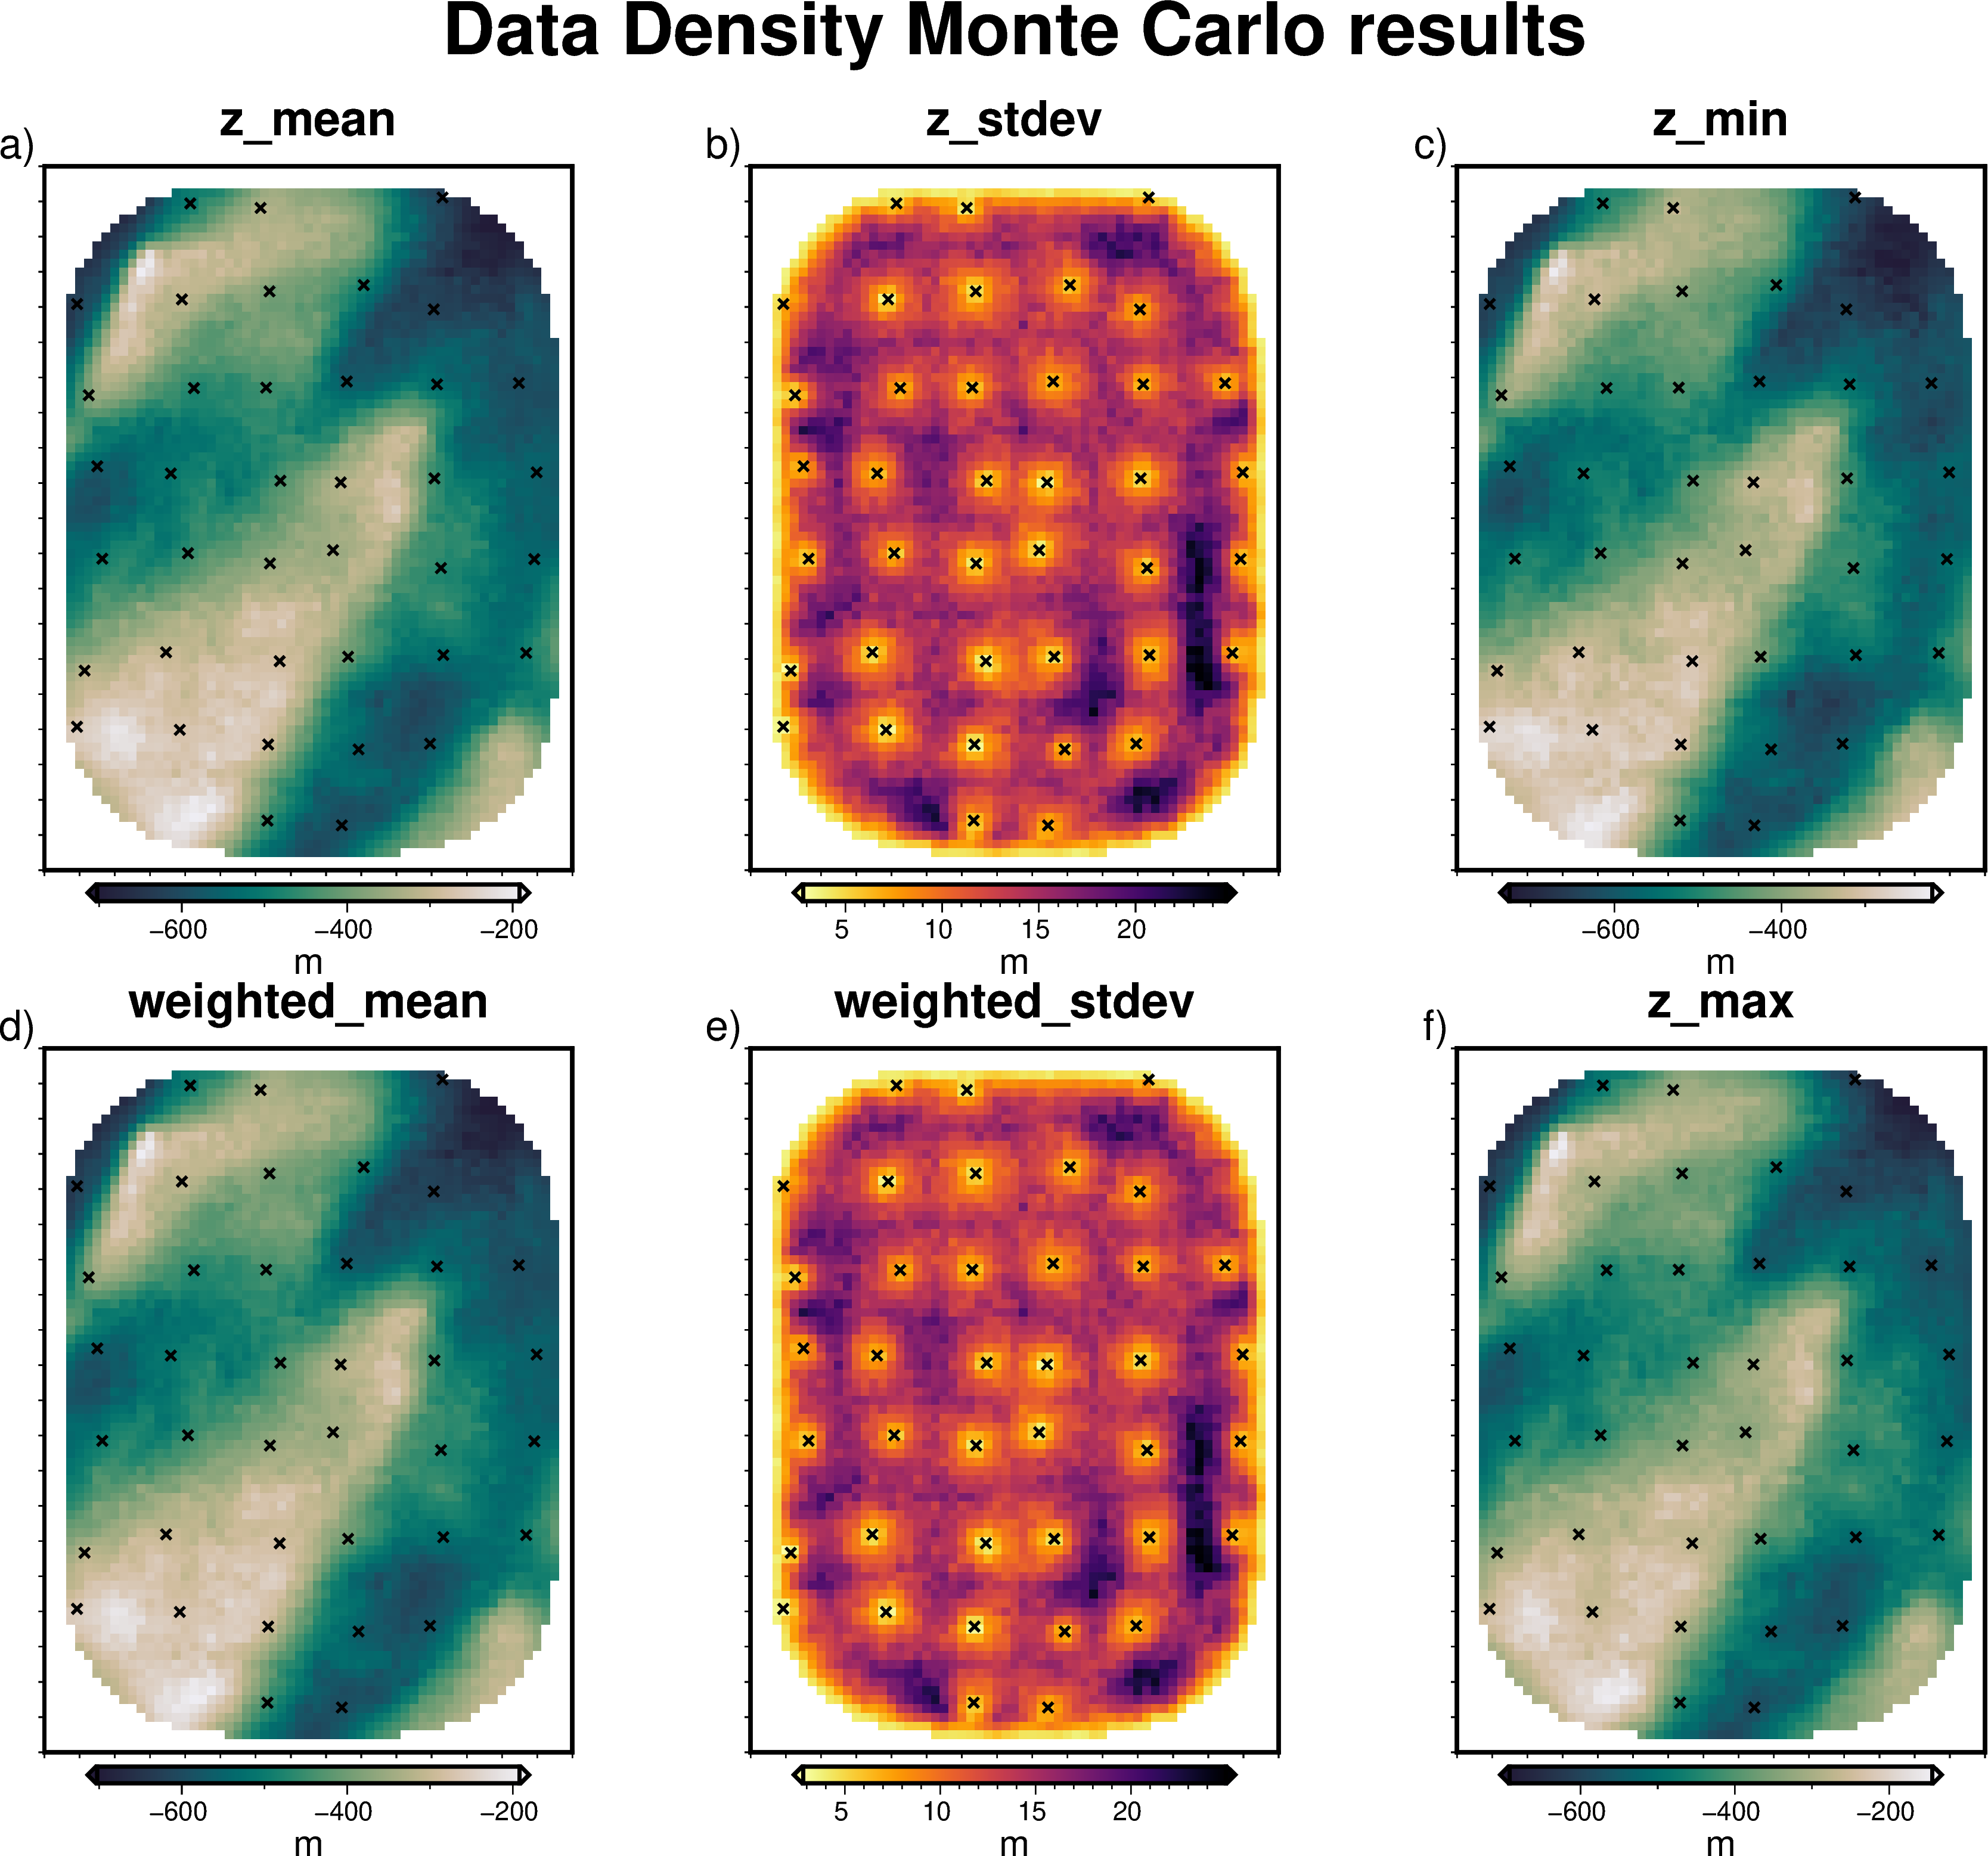

In [67]:
if plot:
    plot_stats(
        "Data Density Monte Carlo results",
        grav_dfs,
    )

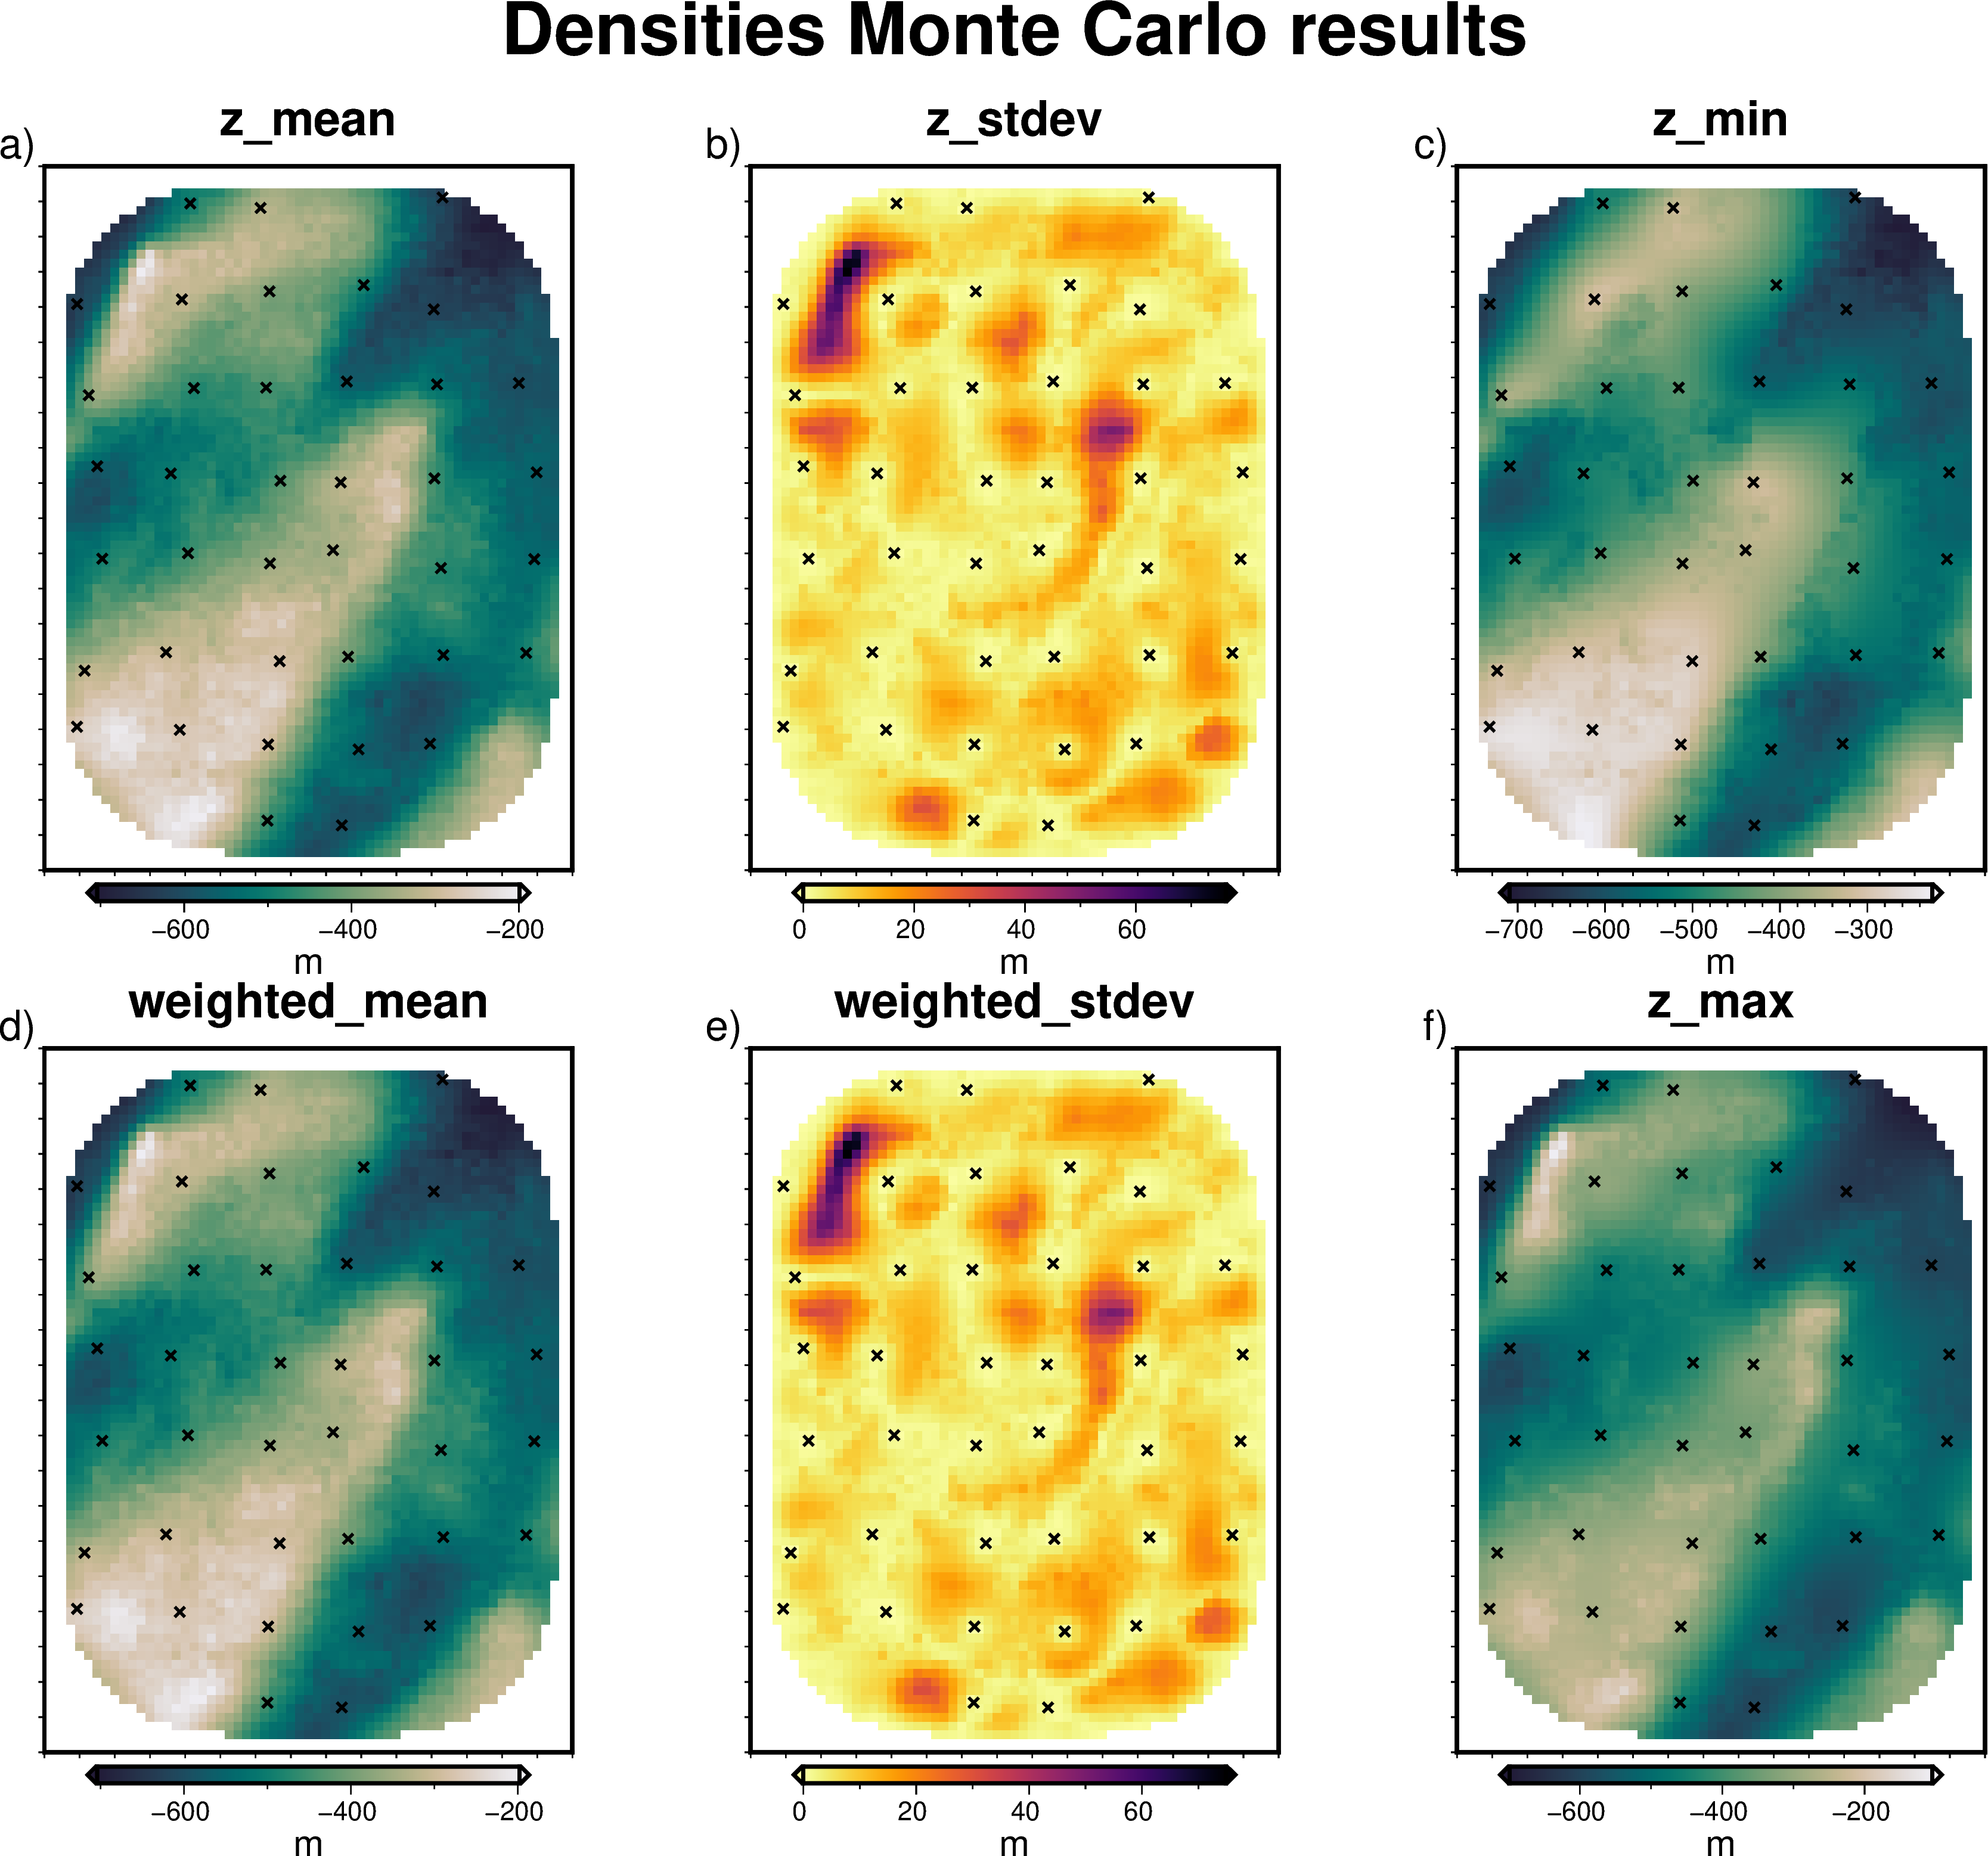

In [69]:
if plot:
    plot_stats(
        "Densities Monte Carlo results",
        grav_dfs,
    )

## Calculate standard deviation
* calculate standard deviation of each grid cell for the entire suite of invert bathymetries

<Axes: xlabel='sediment_density', ylabel='Count'>

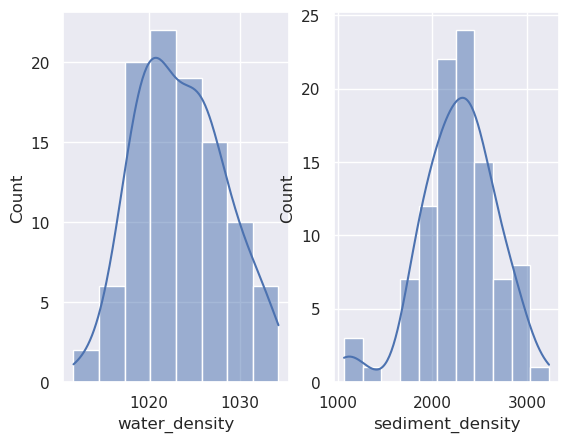

In [70]:
values_df = pd.DataFrame(values)
fig, axes = plt.subplots(1, 2)
sns.histplot(ax=axes[0], data=values_df, x="water_density", kde=True)
sns.histplot(ax=axes[1], data=values_df, x="sediment_density", kde=True)

In [71]:
# grd = ds_merged['run_num'].std("runs").rename("z_std")
# grd = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = grd, masked=True, invert=False)

# fig = maps.plot_grd(
#     grd,
#     cmap="inferno",
#     reverse_cpt=True,
#     robust=True,
#     hist=True,
#     cbar_label="standard deviation (m)",
#     title='Combined Monte Carlo uncertainty',
# )

# fig.plot(
#     x=constraints.easting,
#     y=constraints.northing,
#     fill="black",
#     style="c.01c",
# )
# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     fill="white",
#     pen=".3p,black",
#     style="c.08c",
#     label="Bed constraints",
# )
# fig.legend()

# fig.show()

In [72]:
# grd = ds_merged['run_num'].median("runs").rename("z_median")
# grd = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = grd, masked=True, invert=False)

# fig = maps.plot_grd(
#     grd,
#     cmap="inferno",
#     reverse_cpt=True,
#     robust=True,
#     hist=True,
#     cbar_label="median (m)",
#     title='Combined Monte Carlo median',
# )

# fig.plot(
#     x=constraints.easting,
#     y=constraints.northing,
#     fill="black",
#     style="c.01c",
# )
# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     fill="white",
#     pen=".3p,black",
#     style="c.08c",
#     label="Bed constraints",
# )
# fig.legend()

# fig.show()

In [73]:
# merged_min = ds_merged['run_num'].min("runs")
# merged_max = ds_merged['run_num'].max("runs")
# merged_min = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = merged_min, masked=True, invert=False)
# merged_max = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = merged_max, masked=True, invert=False)

# _ = utils.grd_compare(
#     merged_min,
#     merged_max,
#     plot=True,
#     grid1_name="Min",
#     grid2_name="Max",
#     title='Combined Monte Carlo analysis',
#     cbar_label="variance (m)",
#     diff_cmap="inferno",
#     diff_maxabs=False,
#     cmap="rain",
#     reverse_cpt=True,
#     rmse_in_title=False,
#     subplot_labels=True,
#     robust=True,
#     hist=True,
#     # shp_mask="../plotting/RIS_outline.shp",
# )

In [74]:
# inverted_bathy_mask = utils.mask_from_shp(shapefile="../plotting/RIS_outline.shp", xr_grid = inverted_bathy, masked=True, invert=False)
# max_to_final = merged_max - inverted_bathy_mask
# min_to_final = merged_min - inverted_bathy_mask

# fig = maps.plot_grd(
#     max_to_final,
#     title="Max variance - final model",
#     cmap="vik+h0",
#     robust=True,
#     hist=True,
# )
# fig = maps.plot_grd(
#     min_to_final,
#     title="Min variance - final model",
#     cmap="vik+h0",
#     robust=True,
#     hist=True,
#     fig = fig,
#     origin_shift = "xshift",
# )
# fig.show()